<h1 style="display:none">DETECCIÓN DE FAKE NEWS</h1>


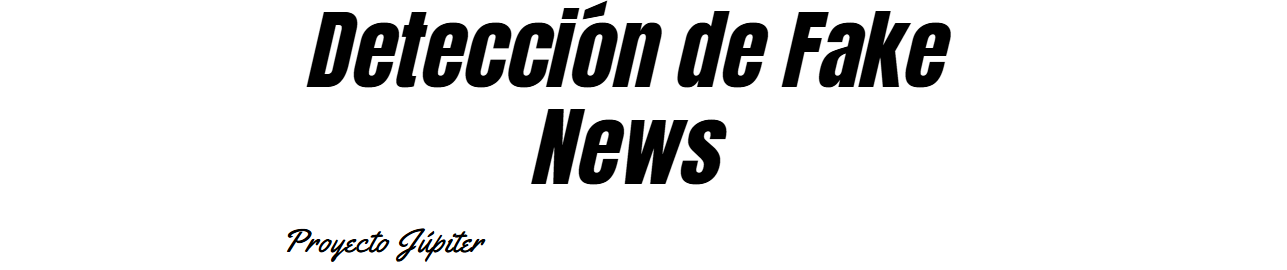

---

### Instalación de librerias

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import json
from textblob import TextBlob
from transformers import pipeline
from collections import Counter 
import re 
import nltk
from nltk.corpus import stopwords

---

## lectura de Jsons

### Tabla contenidos

Cargamos los archivos JSON brutos para convertirlos en DataFrame.

In [4]:
with open('../data/json/contenido.json', encoding='utf-8') as datos_brutos:
  data = json.load(datos_brutos)
df = pd.DataFrame(data)

Comprobamos que la tabla está transpuesta, así que la cambiamos y asignamos los nombres de nuestras columnas.

In [7]:
df1 = df.transpose()  #Transponemos la tabla

df1.columns.values[1] = "texto"  # Asiganamos los nombres de las columnas.
df1.index.name = "id_contenido"
df_contenidos = df1.reset_index()

In [9]:
df_contenidos

id_contenido                                             titulo  \
0            8476                       You Can Smell Hillary’s Fear   
1           10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2            3608        Kerry to go to Paris in gesture of sympathy   
3           10142  Bernie supporters on Twitter erupt in anger ag...   
4             875   The Battle of New York: Why This Primary Matters   
...           ...                                                ...   
6330         4490  State Department says it can't find emails fro...   
6331         8062  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332         8622  Anti-Trump Protesters Are Tools of the Oligarc...   
6333         4021  In Ethiopia, Obama seeks progress on peace, se...   
6334         4330  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                  texto  
0     Daniel Greenfield, a Shillman Journalism Fello...  
1     Google Pinterest Digg Linkedin Reddit Stumbleu...  
2     U.S. Secretary of State John F. Kerry said Mon...  
3     — Kaydee King (@KaydeeKing) November 9, 2016 T...  
4     It's primary day in New York and front-runners...  
...                                                 ...  
6330  The State Department told the Republican Natio...  
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...  
6332   Anti-Trump Protesters Are Tools of the Oligar...  
6333  ADDIS ABABA, Ethiopia —President Obama convene...  
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...  

[6335 rows x 3 columns]

### Tabla compartir tiempo

In [11]:
with open('../data/json/compartir_tiempo.json', encoding='utf-8') as datos_brutos:
  data = json.load(datos_brutos)


Realizamos un bucle for para rellenar dos listas vacías con las claves y valores para posteriormente convertirlo en un diccionario y hacer nuestro DataFrame.

In [14]:
claves=[]
valores=[]

for x in data:
    data[x]

    for y in data[x]:

        claves.append(y)

        valores.append(x)

diccionario={'id_compartir':claves, 'compartir_tiempo': valores}

df_compartir_tiempo = pd.DataFrame(diccionario)

#vaciamos las listas por si las utilizamos mas adelante
valores.clear()  
claves.clear()

df_compartir_tiempo

id_compartir compartir_tiempo
0             4013                1
1             8521                2
2            10531                2
3             7867                2
4              726                2
...            ...              ...
6330          4439              960
6331          3258              960
6332           206              960
6333          1350              960
6334          7122              960

[6335 rows x 2 columns]

### Tabla fake

In [16]:
with open('../data/json/fake.json', encoding='utf-8') as datos_brutos:
  data = json.load(datos_brutos)

Realizamos un bucle for para rellenar dos listas vacías con las claves y valores para posteriormente convertirlo en un diccionario y hacer nuestro DataFrame.

In [43]:
claves=[]
valores=[]

for x in data:
    
    valores.append(data[x])
    claves.append(x)

diccionario={'id':claves, 'fake': valores}
df_fake = pd.DataFrame(diccionario)

#vaciamos las listas por si las utilizamos mas adelante
valores.clear()  
claves.clear()

df_fake

id  fake
0      8476  FAKE
1     10294  FAKE
2      3608  REAL
3     10142  FAKE
4       875  REAL
...     ...   ...
6330   4490  REAL
6331   8062  FAKE
6332   8622  FAKE
6333   4021  REAL
6334   4330  REAL

[6335 rows x 2 columns]

### Tabla info

In [18]:
with open('../data/json/info.json', encoding='utf-8') as datos_brutos:
  data = json.load(datos_brutos)

Realizamos un bucle for para rellenar dos listas vacías con las claves y valores para posteriormente convertirlo en un diccionario y hacer nuestro DataFrame.

Esta tabla JSON contiene 2 tablas de información: Autores y Fuentes. Las dos con sus respectivos Nº de identificación.

In [48]:
for x in data:  #En este caso nuestra tabla json contiene dos tablas. Por lo cual hago un bucle para rellenar las listas, claves y valores, dos veces.
    claves=[]
    valores=[]
    
    for y in data[x]:   #Relleno las listas con los datos de la iteracion que corresponda, Autor o Fuente.
        claves.append(y[0])
        valores.append(y[1])
        
    if x =='autor':   #Si corresponde a la iteracion de los datos de 'Autor' genero este DF     
        diccionario={'id':claves, 'autor': valores}
        df_info = pd.DataFrame(diccionario)
        df_info
    else:            #Si corresponde a la iteracion de los datos de 'fuente' genero este DF     
        diccionario={'id':claves, 'fuente': valores}
        df_fuente = pd.DataFrame(diccionario)
        df_fuente

#vaciamos las listas por si las utilizamos mas adelante
valores.clear()  
claves.clear()


In [49]:
df_info

id         autor
0      8476    Marcus Liu
1     10294     Lily Wang
2      3608    Nora Patel
3     10142     Avery Kim
4       875  Daniel Patel
...     ...           ...
6330   4490       Zoe Lee
6331   8062    Logan Wong
6332   8622     Aria Shah
6333   4021            -1
6334   4330   Ethan Hayes

[6335 rows x 2 columns]

In [50]:
df_fuente

id              fuente
0      8476  The Daily Dispatch
1     10294    Insider Insights
2      3608        Daily Beacon
3     10142           The Pulse
4       875        Morning Star
...     ...                 ...
6330   4490        The Reporter
6331   8062        The Reporter
6332   8622      Global Gazette
6333   4021      Global Insight
6334   4330         Times Today

[6335 rows x 2 columns]

### Tabla metadatos

En este caso podemos generar el DataFrame a partir de la función de pandas para leer los archivos JSON.

In [53]:
df = pd.read_json('data/json/metadatos.json')

Tenemos que transponer las columnas para visualizar la tabla correctamente.

In [55]:
df_metadatos=df.transpose()

In [56]:
df_metadatos

t_id visitas compartir duracion favorito
8476    8476  389073     55938      599     8008
10294  10294  239160     34348      216     7958
3608    3608   48853     43056      447     8145
10142  10142  710817     96927      184     1102
875      875  997280     74788      175     3299
...      ...     ...       ...      ...      ...
4490    4490  600913     22117      108     4299
8062    8062  261047     93829      178     5714
8622    8622  150709     90656      -60     9885
4021    4021  722283     14882      428     5709
4330    4330  593554     68616      373      568

[6335 rows x 5 columns]

### Tabla pais_idioma

In [20]:
with open('../data/json/pais_idioma.json', encoding='utf-8') as datos_brutos:
  data = json.load(datos_brutos)

En este caso vemos que los datos están muy sucios y mal estructurados.

In [60]:
# Leemos la informacion en una tabla con una sola columna para posteriormente limpiarla y separarla
df_pais_idioma = pd.DataFrame(data,columns=['OriginalData'])

# Separación de información en columnas df = originalData - t_id, idiomapais (Separadores ---)
df_pais_idioma[['id','idiomapais']]=df_pais_idioma['OriginalData'].str.split('---',expand=True)

# Creación de columnas apartir de df= idiomapais - idioma, pais (separadores ###)
df_pais_idioma[['pais','idioma']] =df_pais_idioma['idiomapais'].str.split('###',expand=True)
del df_pais_idioma['OriginalData']
del df_pais_idioma['idiomapais']

df_pais_idioma

id           pais   idioma
0      8476  United States  English
1     10294     Bangladesh  English
2      3608       Tanzania  English
3     10142       Thailand  English
4       875          Kenya  English
...     ...            ...      ...
6330   4490     Bangladesh  English
6331   8062   South Africa  English
6332   8622          China  English
6333   4021        Ukraine  English
6334   4330         Uganda  English

[6335 rows x 3 columns]

### Tabla tiempo

In [22]:
with open('../data/json/tiempo.json', encoding='utf-8') as datos_brutos:
  data = json.load(datos_brutos)

Realizamos un bucle for para rellenar dos listas vacías con las claves y valores para posteriormente convertirlo en un diccionario y hacer nuestro DataFrame.

In [64]:
claves=[]
valores=[]

for x in data:
    data[x]

    for y in data[x]:
        claves.append(y)
        valores.append(x)

diccionario={'id':claves, 'tiempo': valores}
df_tiempo = pd.DataFrame(diccionario)

#vaciamos las listas por si las utilizamos mas adelante
valores.clear()  
claves.clear()

df_tiempo

id tiempo
0      6220      1
1      2831      1
2      5951      1
3       139      2
4      9680      2
...     ...    ...
6330   2433    959
6331  10447    959
6332   6442    960
6333   4253    960
6334   4499    960

[6335 rows x 2 columns]

### Tabla tipo

In [24]:
with open('../data/json/tipo.json', encoding='utf-8') as datos_brutos:
  data = json.load(datos_brutos)

In [67]:
claves=[]
valores=[]

for x in data:   
    for y in data[x]:
        valores.append(x)
        claves.append(y)

        
diccionario={'id':claves, 'tipo': valores}
df_tipo = pd.DataFrame(diccionario)


#vaciamos las listas por si las utilizamos mas adelante
valores.clear()  
claves.clear()

df_tipo  

id               tipo
0     3608            Columna
1     4869            Columna
2      139            Columna
3     3424            Columna
4     1718            Columna
...    ...                ...
6024  7675  Noticia destacada
6025  3658  Noticia destacada
6026  1736  Noticia destacada
6027  7836  Noticia destacada
6028  4515  Noticia destacada

[6029 rows x 2 columns]

## EDA: Análisis Exploratorio de datos

### EDA tabla df_contenidos

In [70]:
df_contenidos.head()

id_contenido                                             titulo  \
0         8476                       You Can Smell Hillary’s Fear   
1        10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2         3608        Kerry to go to Paris in gesture of sympathy   
3        10142  Bernie supporters on Twitter erupt in anger ag...   
4          875   The Battle of New York: Why This Primary Matters   

                                               texto  
0  Daniel Greenfield, a Shillman Journalism Fello...  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  
2  U.S. Secretary of State John F. Kerry said Mon...  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  
4  It's primary day in New York and front-runners...

#### Tipo de datos

La tabla df_contenidos consta de 3 columnas, la columna 'id_contenido' que representa el identificador único de la noticia, la columna 'titulo' que contiene el título con el que se identifica la noticia y por último la columna 'texto' que contiene texto íntegro de cada noticia.

In [73]:
df_contenidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_contenido  6335 non-null   object
 1   titulo        6335 non-null   object
 2   texto         6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


Podemos ver que la columna id_contenido debería ser una columna numérica, sin embargo, es de tipo object. Así que vamos a cambiarle el tipo de dato.

In [75]:
df_contenidos['id_contenido']=df_contenidos['id_contenido'].astype(int)

#### Dimensiones

In [77]:
df_contenidos.shape

(6335, 3)

In [78]:
df_contenidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_contenido  6335 non-null   int32 
 1   titulo        6335 non-null   object
 2   texto         6335 non-null   object
dtypes: int32(1), object(2)
memory usage: 123.9+ KB


Vamos a calcular los rangos en los que se mueve cada una de las tres columnas

In [80]:
#Rango de la columna id_contenido

print(f"El valor maximo de la columna id_contenido es {df_contenidos['id_contenido'].max()}")
print(f"El valor minimo de la columna id_contenido es {df_contenidos['id_contenido'].min()}")

El valor maximo de la columna id_contenido es 10557
El valor minimo de la columna id_contenido es 2


In [81]:
#Rango de la columna titulo

longitud_titulo = df_contenidos['titulo'].apply(len)

print(f"El numero de caracteres maximo de la columna titulo es {longitud_titulo.max()}")
print(f"El numero de caracteres minimo de la columna titulo es {longitud_titulo.min()}")

El numero de caracteres maximo de la columna titulo es 289
El numero de caracteres minimo de la columna titulo es 1


In [82]:
#Rango de la columna texto

longitud_texto = df_contenidos['texto'].apply(len)

print(f"El numero de caracteres maximo de la columna texto es {longitud_texto.max()}")
print(f"El numero de caracteres minimo de la columna texto es {longitud_texto.min()}")

El numero de caracteres maximo de la columna texto es 115372
El numero de caracteres minimo de la columna texto es 1


Ahora revisaremos la media de caracteres que tiene las columnas con caracteres, en este caso 'titulo' y 'texto'

In [84]:
# Media de caracteres en la columna titulo

longitud_titulo = df_contenidos['titulo'].apply(len)

print(f"El numero de caracteres medio de la columna titulo es {longitud_titulo.mean()}")

El numero de caracteres medio de la columna titulo es 65.2776637726914


In [85]:
# Media de caracteres en la columna texto

longitud_texto = df_contenidos['texto'].apply(len)

print(f"El numero de caracteres medio de la columna texto es {longitud_texto.mean()}")

El numero de caracteres medio de la columna texto es 4707.250355169692


In [86]:
#Rango en numero de palabras de la columna texto

numero_palabras_texto = df_contenidos['texto'].apply(lambda x: len(x.split()))

print(f"El numero de palabras minimo de la columna texto es {numero_palabras_texto.min()}")
print(f"El numero de palabras maximo de la columna texto es {numero_palabras_texto.max()}")
print(f"El numero de palabras medio de la columna texto es {round(numero_palabras_texto.mean(),2)}")

El numero de palabras minimo de la columna texto es 0
El numero de palabras maximo de la columna texto es 20891
El numero de palabras medio de la columna texto es 776.3


#### Duplicados

La columna id_contenido no tiene duplicados

In [89]:
df_contenidos['id_contenido'].duplicated().value_counts()

id_contenido
False    6335
Name: count, dtype: int64

La columna 'titulo' tiene 79 celdas duplicados, entendemos que es normal que se repitan titulos de noticias

###### df_contenidos['titulo'].duplicated().value_counts()

La columna 'texto' tiene 275 celdas duplicados

In [93]:
df_contenidos['texto'].duplicated().value_counts()

texto
False    6060
True      275
Name: count, dtype: int64

Ahora vamos a generar un df provisional donde juntemos las noticias cuyo titulo y texto sea duplicado, para comprobar si hay alguna noticia en la que se el titulo y el texto sea el mismo. 

In [95]:
duplicadas = df_contenidos[df_contenidos[['texto', 'titulo']].duplicated(keep=False)]
df_duplicados = duplicadas.sort_values(by=['texto', 'titulo'])
df_duplicados.head()

id_contenido                                             titulo  \
1796          5608     Fighting Ghost Fascists While Aiding Real Ones   
5083         10399     Fighting Ghost Fascists While Aiding Real Ones   
584           9652  Hillary’s “Big Tent” is Obama’s “Grand Bargain...   
6148          9725  Hillary’s “Big Tent” is Obama’s “Grand Bargain...   
863           2905      US faces calls to ‘walk away’ from Iran talks   

                                                  texto  
1796  2016 presidential campaign by BAR executive ed...  
5083  2016 presidential campaign by BAR executive ed...  
584   2016 presidential campaign by BAR executive ed...  
6148  2016 presidential campaign by BAR executive ed...  
863   A leading Republican critic of the Iranian nuc...

Descubrimos que hay 57 noticias en las cuales el título y texto es exactamente el mismo que al menos otra noticia.

In [97]:
df_duplicados.shape

(57, 3)

#### Nulos y valores atípicos

Vemos que la tabla a primera vista no tiene ningun nulo.

In [100]:
df_contenidos.isnull().sum()

id_contenido    0
titulo          0
texto           0
dtype: int64

Pero cuando hemos revisado el rango de caracteres de las columnas titulo y texto hemos visto que tenian celdas con 1 caracter. Asi que vamos a visualizar esas celdas para comprobar de que se trata.

In [102]:
# compruebo que si hay un titulo de 1 solo caracter

titulos_de_1_caracter = df_contenidos[df_contenidos['titulo'].apply(len) == 1]
titulos_de_1_caracter

id_contenido titulo                                              texto
3456          9694      :   We the People Against Tyranny: Seven Princi...

Sustitiremos el titulo ':' por 'No registra'

In [104]:
df_contenidos['titulo'] = df_contenidos['titulo'].replace(':' ,'No registra' )

In [105]:
# compruebo que hay 35 textos que tienen un solo caracter correspondiente a un espacio en blanco.

texto_de_1_caracter = df_contenidos[df_contenidos['texto'].apply(len) == 1]
texto_de_1_caracter.head(10)

id_contenido                                             titulo texto
106           5530  The Arcturian Group by Marilyn Raffaele Octobe...      
710           8332  MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...      
806           9314  Southern Poverty Law Center Targets Anti-Jihad...      
919          10304  Refugee Resettlement Watch: Swept Away In Nort...      
940           9474  Michael Bloomberg Names Technological Unemploy...      
1664          5802  Alert News : Putins Army Is Coming For World W...      
1736          9564  An LDS Reader Takes A Look At Trump Accuser Je...      
1851          5752  America’s Senator Jeff Sessions Warns of Worse...      
1883          8816  Paris Migrant Campers Increase after Calais Is...      
1941          7525  Putins Army is coming for World war 3 against ...

Rellenamos los campos de texto en blanco con 'No registra'

In [107]:
df_contenidos['texto'] = df_contenidos['texto'].replace(' ' ,'No registra' )

#### Análisis de columna 'titulo'

Convertimos 'longitud_titulo', que utilizamos al principio para contar el numero de caracteres en Df para trabajar mas comodamente con él.

In [110]:
df_longitud_titulo = pd.DataFrame(longitud_titulo)

df_longitud_titulo.rename(columns={'titulo':'longitud'},inplace=True)

In [111]:
df_longitud_titulo['longitud'].describe()

count    6335.000000
mean       65.277664
std        23.733657
min         1.000000
25%        49.000000
50%        64.000000
75%        78.000000
max       289.000000
Name: longitud, dtype: float64

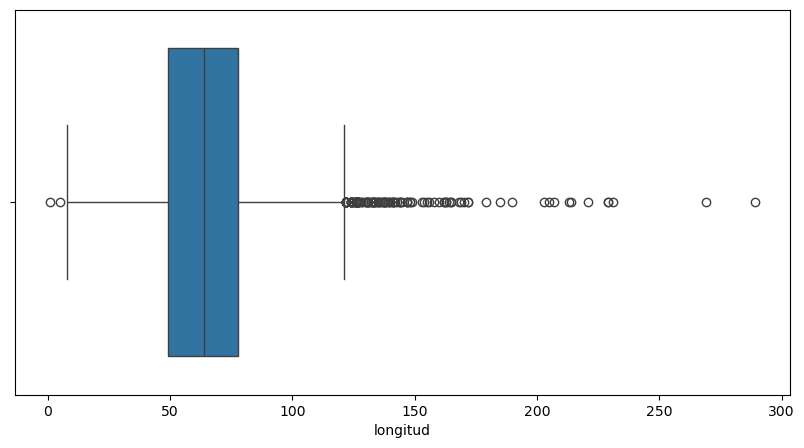

In [112]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_longitud_titulo['longitud'])
plt.show()

Comprobamos que la mayoría de noticias tiene un titular con entre 1 y 104 caracteres

In [114]:
division_percentiles_titulo =df_longitud_titulo['longitud'].quantile([0.75,0.85,0.95,1])

In [115]:
division_percentiles_titulo

0.75     78.0
0.85     87.0
0.95    104.0
1.00    289.0
Name: longitud, dtype: float64

#### Análisis columna 'texto'

convertimos 'longitud_texto' que utilizamos para medir el numero de caracteres de los textos en Df para trabajar mas comodamente con él.

In [118]:
df_longitud_texto = pd.DataFrame(longitud_texto)

df_longitud_texto.rename(columns={'texto':'longitud'},inplace=True)

In [119]:
df_longitud_texto['longitud'].describe()

count      6335.000000
mean       4707.250355
std        5090.956446
min           1.000000
25%        1741.500000
50%        3642.000000
75%        6192.000000
max      115372.000000
Name: longitud, dtype: float64

Pintamos un grafico para ver donde como se distribuyen los numeros de caracteres.

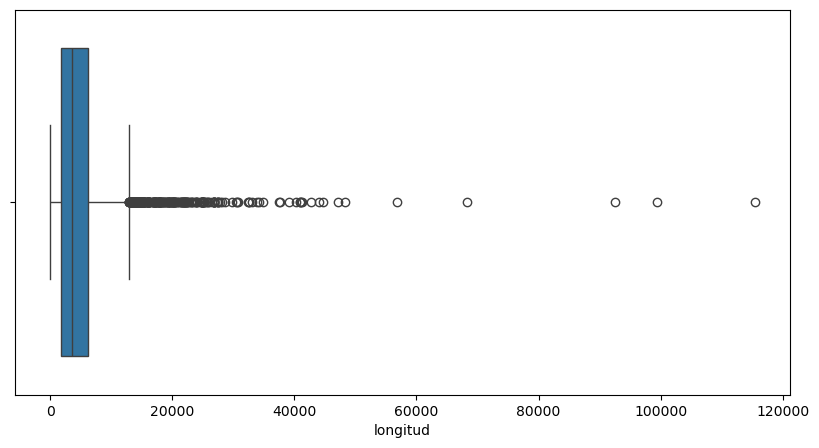

In [121]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_longitud_texto['longitud'])
plt.show()

Vemos que hay varios textos que están fuera de rango, así que calculamos los percentiles a partir del tercer cuartil para ver como se distribuye.

In [123]:
division_percentiles =df_longitud_texto['longitud'].quantile([0.75,0.85,0.95,1])

In [124]:
division_percentiles

0.75      6192.0
0.85      7899.8
0.95     12247.3
1.00    115372.0
Name: longitud, dtype: float64

Vemos que la inmensa mayoría de textos tiene entre 11 y 5000 caracteres más o menos.

Ahora vamos a analizar las palabras más comunes dentro de la columna 'texto'

In [127]:
all_words = ''.join(df_contenidos['texto']).lower() #''.join(df['article']): Une todos los artículos en una sola cadena de texto. 
                                                    #.lower(): Convierte todo el texto a minúsculas para que el análisis no sea sensible a mayúsculas y minúsculas.

all_words = re.findall(r'\b\w+\b', all_words)#Esto devuelve una lista de todas las palabras encontradas en el texto.
                                             #re.findall(r'\b\w+\b', all_words): Utiliza una expresión regular para encontrar todas las palabras en el texto.
                                             #*\b indica un límite de palabra. 
                                             #*\w+ encuentra una o más letras, números o guiones bajos.
                                             #*\b indica el final de una palabra.

word_freq = Counter(all_words) #Counter(all_words): Crea un objeto Counter que cuenta la frecuencia de cada palabra en la lista all_words.
word_freq.most_common(10) #word_freq.most_common(10): Devuelve una lista de las 10 palabras más comunes y sus frecuencias


[('the', 290947),
 ('to', 139880),
 ('of', 129859),
 ('and', 120142),
 ('a', 108710),
 ('in', 98720),
 ('that', 72594),
 ('s', 62113),
 ('is', 54434),
 ('for', 46478)]

Las palabras más repetidas no aportan mucho valor en sí (stop words), por lo que realizaremos un análisis enfocado a temas recurrentes, análisis de sentimiento y detección de tendencias.

In [903]:
# Descargar lista de palabras vacías

stop_words = set(stopwords.words('english'))

# Filtrar palabras vacías
filtered_words = [word for word in all_words if word not in stop_words]

# Recalcular la frecuencia de palabras
word_freq = Counter(filtered_words)
word_freq.most_common(20)

[('trump', 22426),
 ('said', 21212),
 ('clinton', 17497),
 ('would', 12780),
 ('one', 11876),
 ('people', 11748),
 ('new', 9323),
 ('state', 9211),
 ('president', 8831),
 ('obama', 8228),
 ('also', 8225),
 ('us', 7864),
 ('campaign', 7719),
 ('like', 7247),
 ('hillary', 7201),
 ('time', 6958),
 ('could', 6560),
 ('even', 6482),
 ('states', 6236),
 ('republican', 5933)]

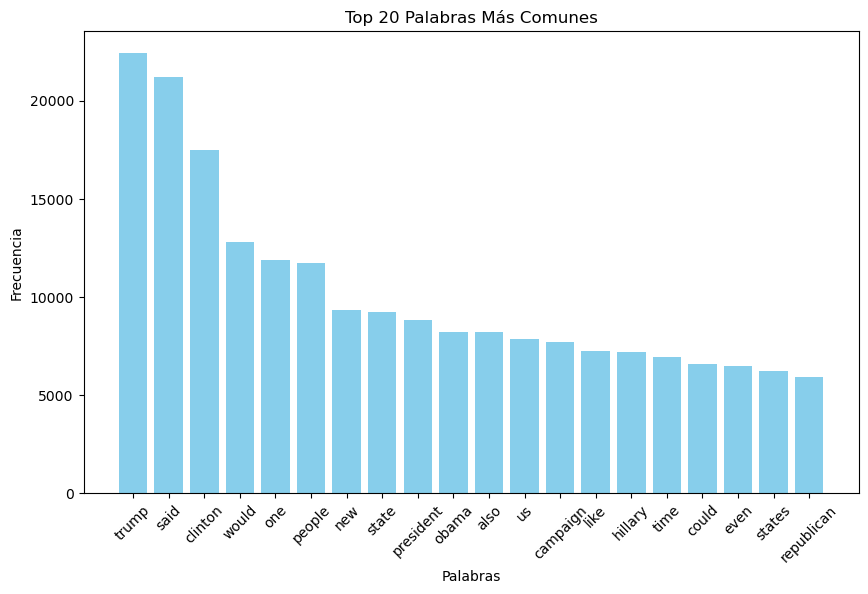

In [130]:
# visualizamos estás palabras en un grafico.
palabras_comunes = word_freq.most_common(20)
palabras, frecuencias =zip(*palabras_comunes)
plt.figure(figsize=(10, 6))
plt.bar(palabras, frecuencias, color='skyblue')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Top 20 Palabras Más Comunes')
plt.xticks(rotation=45)
plt.show()

De este análisis de las palabras más repetidas podemos sacar varias conclusiones:

* Las palabras más frecuentes como "trump", "clinton", "president", "obama", "campaign", "hillary", "states", y "republican" indican que los artículos se centran en temas políticos, especialmente en figuras políticas y posiblemente campañas electorales.
* "Trump" y "Clinton" son las palabras más comunes, lo que sugiere que muchos artículos se enfocan en Donald Trump y Hillary Clinton. Esto podría estar relacionado con las elecciones presidenciales de EE. UU. y sus respectivas campañas.
* La presencia de palabras como "state" y "states" sugiere que los artículos también discuten temas relacionados con diferentes estados dentro de EE. UU.
* Palabras como "time" y "new" pueden indicar que los artículos discuten eventos recientes o históricos, proporcionando un contexto temporal a las noticias.

#### Nueva columna

Analizando el dataframe echamos en falta saber la temática de cada noticia, por lo que vamos a generar una columna mediante la API de ChatGPT que nos indique la temática de cada noticia de entre una lista  
de opciones que le pasamos:

- Ciencia
- Tecnología
- Salud
- Educación
- Deportes
- Arte
- Historia
- Economía
- Política
- Sociedad
- No clasificado

Realizaremos el código con el prompt en Visual Studio code por comodidad. lo encontraremos en la ruta "Promts\Generar tematica noticias\Data_frames"







Generamos un archivo csv con nuestra df_contenidos para leerla en VSC

In [136]:
#df_contenidos.to_csv('PROPUESTA IA GENERATIVA/Generar tematica noticias/Data_frames/df_contenidos.csv', index=False, encoding='utf-8')  

Una vez generada la columna leemos el csv con la tabla que incluye la columna 'tematica'

In [905]:
df_contenidos = pd.read_csv("data/csv/df_contenidos_limpio.csv")

In [907]:
tematicas = df_contenidos.groupby('tematica')['id_contenido'].count().reset_index(name='num_noticias').sort_values(by='num_noticias', ascending = False)
tematicas['porcentaje_noticias'] = round( tematicas['num_noticias'] / (tematicas['num_noticias'].sum()) *100,2) 

Descubrimos que el 76% de las noticias publicadas son de temática política.

In [910]:
tematicas

tematica  num_noticias  porcentaje_noticias
7         Política          4828                76.21
10        Sociedad           582                 9.19
9            Salud           222                 3.50
3         Economía           213                 3.36
11      Tecnología           113                 1.78
6   No clasificado           100                 1.58
5         Historia            99                 1.56
1          Ciencia            87                 1.37
4        Educación            44                 0.69
0             Arte            23                 0.36
2         Deportes            23                 0.36
8         Religión             1                 0.02

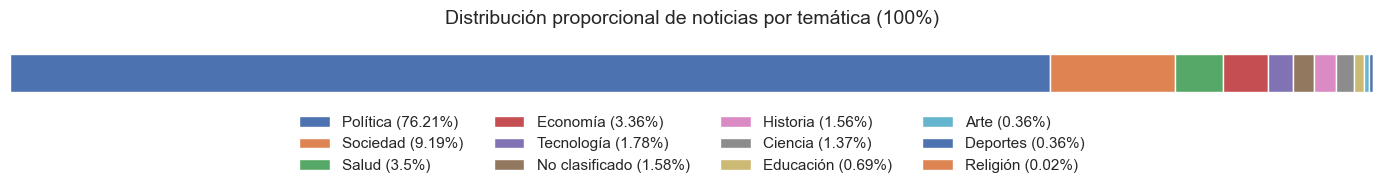

In [912]:
fig, ax = plt.subplots(figsize=(14, 2))
left = 0
bars = []

for i, row in tematicas.iterrows():
    width = row['porcentaje_noticias'] / 100
    bar = ax.barh(0, width, left=left, label=f"{row['tematica']} ({row['porcentaje_noticias']}%)")
    bars.append(bar)
    left += width

ax.set_xlim(0, 1)
ax.axis('off')
ax.set_title("Distribución proporcional de noticias por temática (100%)", fontsize=14, pad=20)

ax.legend(ncol=4, bbox_to_anchor=(0.5, -0.2), loc='upper center', frameon=False)
plt.subplots_adjust(bottom=0.8)

plt.tight_layout()
plt.show()

#### Resumen

**Como resumen de este análisis podemos sacar:**

*   La tabla contenida consta de 3 columnas id_contenido(int), título(object) y texto(object)
*   La columna  título es de tipo object y tiene entre 1 y 289 caracteres. Además, tiene una media de 65 caracteres.
*   La columna texto es de tipo object y tiene entre 11 y 115372 caracteres. Además, tiene una media de 4707 caracteres.
*   La tabla no tiene ningún valor nulo.
*   En la columna texto tenía 35 campos en blanco que sustituimos por 'No registra'
*   En la columna título tenía 1 campos con el valor ':' que sustituimos por 'No registra'
*   La columna id_contenido no tiene duplicados
*   La columna título tiene 79 duplicados
*   La columna texto tiene 275 duplicados
*   Hay 59 noticias que tienen el mismo título y texto que al menos otra noticia más.
*   El número de caracteres de los títulos se distribuyen principalmente entre 1 y 80 caracteres.
*   La inmensa mayoría de textos tienen entre 11 y 5000 caracteres más o menos
*   Los textos tienen un máximo de 20891 palabras, pero la mayoría de ellos están entre 0 y 1024 palabras.

### EDA tabla df_compartir_tiempo

In [146]:
df_compartir_tiempo.head(10)

id_compartir compartir_tiempo
0          4013                1
1          8521                2
2         10531                2
3          7867                2
4           726                2
5          8545                2
6          7266                2
7          3787                2
8          6784                3
9          8925                3

#### Tipo de datos

La tabla 'tipo de datos' consta de las columnas 'id_compartir' que representa el identificador único de la noticia y la columna 'compartir_tiempo' que al igual que en el campo de 'tiempo' refleja la unidad de tiempo (número entero) que representa el momento en el que se comparte el artículo periodístico.

In [149]:
df_compartir_tiempo.info()# vemos que la columna 'compartir_tiempo' es de tipo object.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_compartir      6335 non-null   int64 
 1   compartir_tiempo  6335 non-null   object
dtypes: int64(1), object(1)
memory usage: 99.1+ KB


Cambiamo el tipo de dato a la columna 'compartir tiempo' ya que entendemos que debe ser de tipo int

In [151]:
df_compartir_tiempo['compartir_tiempo']=df_compartir_tiempo['compartir_tiempo'].astype('int64')

comprobamos que las dos columnas son de tipo int64

In [153]:
df_compartir_tiempo.dtypes

id_compartir        int64
compartir_tiempo    int64
dtype: object

#### Dimensiones

In [155]:
df_compartir_tiempo.shape

(6335, 2)

El valor minimo de la columna 'compartir_tiempo'

In [157]:
df_compartir_tiempo['compartir_tiempo'].min()

1

El valor maximo de la columna 'compartir_tiempo'

In [159]:
df_compartir_tiempo['compartir_tiempo'].max()

960

Visualizamos la distribución de los valores de la tabla.

In [161]:
df_compartir_tiempo.describe()

id_compartir  compartir_tiempo
count   6335.000000       6335.000000
mean    5280.415627        480.672139
std     3038.503953        277.421264
min        2.000000          1.000000
25%     2674.500000        236.500000
50%     5271.000000        478.000000
75%     7901.000000        719.000000
max    10557.000000        960.000000

#### Duplicados

Comprobamos los duplicados solo en la fila 'id_compartir_t' ya que en la columna'compartir_tiempo' tienen que repetirse muchos valores ya que no son valores unicos. La columna 'id_compartir_t' no tiene duplicados.

In [164]:
df_compartir_tiempo['id_compartir'].duplicated().unique()

array([False])

#### Nulos

La tabla no tiene valores nulos en ninguna de sus columnas.

In [167]:
pd.isnull(df_compartir_tiempo).sum()

id_compartir        0
compartir_tiempo    0
dtype: int64

#### Analisis

Primero vamos a visualizar las horas que se repiten más, es decir, las horas en las que se comparten más noticias.

In [170]:
frecuencia_horas_compartir=df_compartir_tiempo.groupby('compartir_tiempo')['id_compartir'].count().reset_index().sort_values(by='id_compartir',ascending=False).head(20)
frecuencia_horas_compartir.head()

compartir_tiempo  id_compartir
946               948            19
228               229            16
461               462            16
194               195            15
718               719            15

In [171]:
frecuencia_horas_compartir['compartir_tiempo']=frecuencia_horas_compartir['compartir_tiempo'].astype(object)

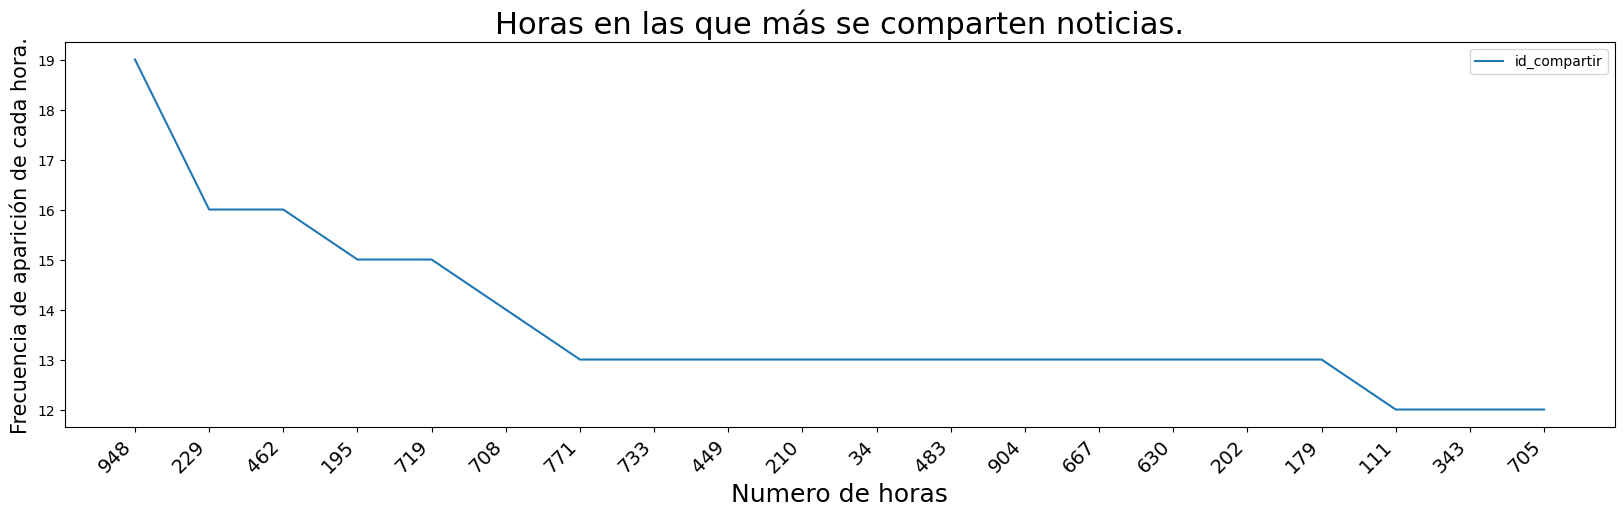

In [172]:
fig,ax= plt.subplots(figsize=(20,5))
frecuencia_horas_compartir.plot(x='compartir_tiempo',y='id_compartir',ax=ax)
ax.set_title('Horas en las que más se comparten noticias.',fontsize=22)
ax.set_xlabel('Numero de horas',fontsize=18)
ax.set_xticks(range(len(frecuencia_horas_compartir))) 
ax.set_xticklabels(frecuencia_horas_compartir['compartir_tiempo'], rotation=45, ha='right', fontsize=14)
ax.set_ylabel('Frecuencia de aparición de cada hora.',fontsize=15)
plt.show()

Pintamos un histograma también para ver la distribucion general de las horas en las que se comparten las noticias.

<Axes: >

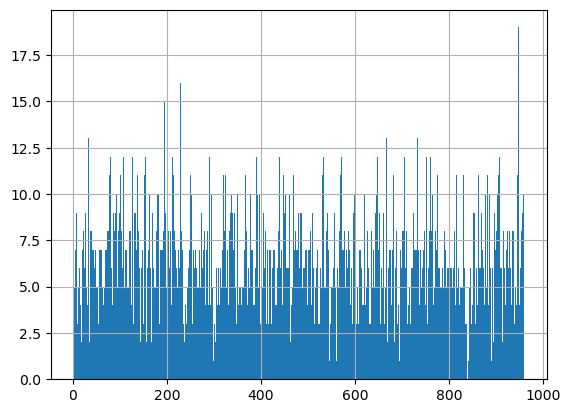

In [174]:
df_compartir_tiempo['compartir_tiempo'].hist(bins=950)

Una vez pintado el grafico comprobamos que la hora en las que más se han compartido noticias es la 948

In [176]:
horas_menos_noticias=df_compartir_tiempo.groupby('compartir_tiempo')['id_compartir'].count().reset_index(name="num_noticias").sort_values(by='num_noticias',ascending=False).head(5)
horas_menos_noticias

compartir_tiempo  num_noticias
946               948            19
228               229            16
461               462            16
194               195            15
718               719            15

Ahora vamos a ver las horas en las que menos noticias se han compartido.

In [178]:
frecuencia_horas_compartir=df_compartir_tiempo.groupby('compartir_tiempo')['id_compartir'].count().reset_index(name="num_noticias").sort_values(by='num_noticias',ascending=False).tail(20)
frecuencia_horas_compartir.sort_values(by='num_noticias')

compartir_tiempo  num_noticias
753               754             1
497               498             1
694               695             1
355               356             1
545               546             1
13                 14             1
560               561             1
298               299             1
839               841             1
0                   1             1
889               891             1
697               698             2
410               411             2
912               914             2
893               895             2
462               463             2
237               238             2
143               144             2
469               470             2
735               736             2

Después de analizar las horas de publicación en formato numérico, vamos a añadir las columnas 'fecha' y 'hora' que representaran la fecha y la hora en la que se comparte cada noticia

In [180]:
fecha_inicio = pd.Timestamp('2022-09-01 07:00:00')

df_compartir_tiempo['fecha_compartir'] = (fecha_inicio + pd.to_timedelta(df_compartir_tiempo['compartir_tiempo'], unit='h')).dt.date
df_compartir_tiempo['hora_compartir'] = (fecha_inicio + pd.to_timedelta(df_compartir_tiempo['compartir_tiempo'], unit='h')).dt.time

In [181]:
df_compartir_tiempo

id_compartir  compartir_tiempo fecha_compartir hora_compartir
0             4013                 1      2022-09-01       08:00:00
1             8521                 2      2022-09-01       09:00:00
2            10531                 2      2022-09-01       09:00:00
3             7867                 2      2022-09-01       09:00:00
4              726                 2      2022-09-01       09:00:00
...            ...               ...             ...            ...
6330          4439               960      2022-10-11       07:00:00
6331          3258               960      2022-10-11       07:00:00
6332           206               960      2022-10-11       07:00:00
6333          1350               960      2022-10-11       07:00:00
6334          7122               960      2022-10-11       07:00:00

[6335 rows x 4 columns]

Vamos a visualizar los dias en que mas noticias se han publicado

In [183]:
df_5=df_compartir_tiempo.groupby(['fecha_compartir']).agg({'compartir_tiempo':'count'}).reset_index() 
df_5.rename(columns={'compartir_tiempo':'Nº noticias publicadas'},inplace=True) #Renombramos una columna para hacerlo mas legible
df_5.sort_values(by='fecha_compartir',inplace=True) # ordenamos el df por dia

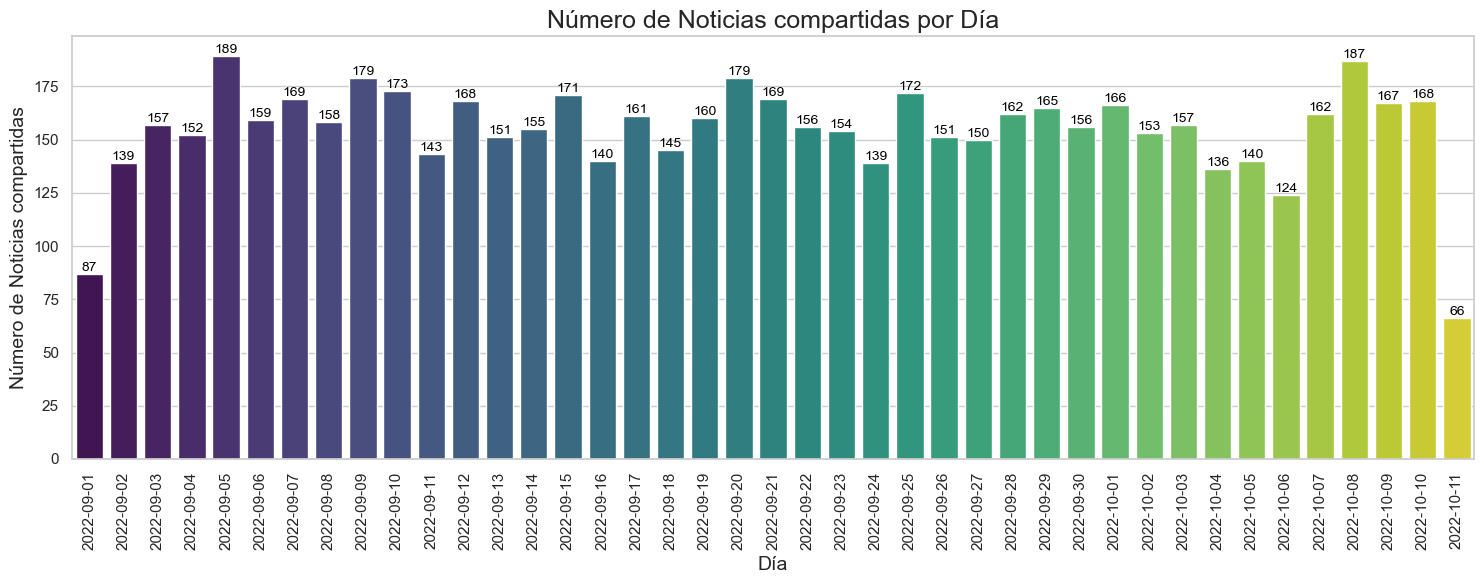

In [184]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 6))
barplot = sns.barplot(
    x='fecha_compartir',
    y='Nº noticias publicadas',
    hue='fecha_compartir', 
    data=df_5,
    palette='viridis',
    legend=False)

for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{int(height)}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     fontsize=10, color='black')

plt.title('Número de Noticias compartidas por Día', fontsize=18)
plt.xlabel('Día', fontsize=14)
plt.ylabel('Número de Noticias compartidas', fontsize=14)


plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Observamos que el día que más noticias se comparten es el 5 de septiembre del 2022 con un total de 189 noticias compartidas.

In [186]:
df_5[df_5['Nº noticias publicadas']==df_5['Nº noticias publicadas'].max()]

fecha_compartir  Nº noticias publicadas
4      2022-09-05                     189

El día que menos noticias se comparten es el 11 de octubre del 2022 con un total de 66 noticias.

In [188]:
df_5[df_5['Nº noticias publicadas']==df_5['Nº noticias publicadas'].min()]

fecha_compartir  Nº noticias publicadas
40      2022-10-11                      66

También vamos a visualizar las noticia compartidas por horas.

In [190]:
df_6=df_compartir_tiempo.groupby(['hora_compartir']).agg({'compartir_tiempo':'count'}).reset_index()
df_6.rename(columns={'compartir_tiempo':'Nº noticias publicadas'},inplace=True) 
df_6.sort_values(by='hora_compartir',inplace=True) # ordenamos el df por dia

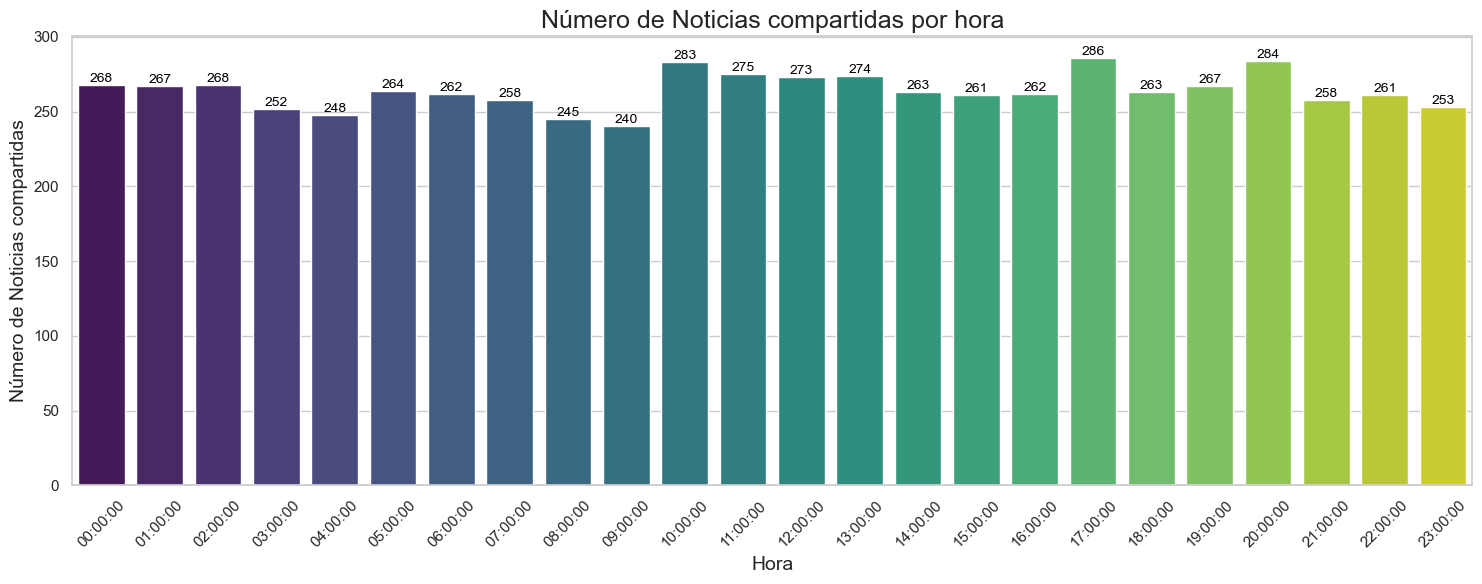

In [191]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 6))
barplot = sns.barplot(
    x='hora_compartir',
    y='Nº noticias publicadas',
    hue='hora_compartir', 
    data=df_6,
    palette='viridis',
    legend=False)

for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{int(height)}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     fontsize=10, color='black')

plt.title('Número de Noticias compartidas por hora', fontsize=18)
plt.xlabel('Hora', fontsize=14)
plt.ylabel('Número de Noticias compartidas', fontsize=14)


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las horas en las que más noticias se han compartido son las 17:00, con un total de 286 noticias compartidas.

In [193]:
df_6[df_6['Nº noticias publicadas']==df_6['Nº noticias publicadas'].max()]

hora_compartir  Nº noticias publicadas
17       17:00:00                     286

Las horas en las que menos noticias se han compartido son las 09:00, con un total de 240 noticias compartidas.

In [195]:
df_6[df_6['Nº noticias publicadas']==df_6['Nº noticias publicadas'].min()]

hora_compartir  Nº noticias publicadas
9       09:00:00                     240

#### Resumen

**Como resumen de este análisis podemos sacar:**


*   La tabla compartir_tiempo consta de 6335 filas y 2 columnas.
*   El valor mínimo de la columna compartir_tiempo es 1 y valor máximo 960.
*   La columna compartir tiempo tiene duplicados, pero es normal, ya que representa el momento en el que se compartió cada noticia.
*   La columna id_compartir_t la cual es el identificador  no tiene duplicados.
*   La tabla no tiene valores nulos en ninguna columna.
*   Las horas en las que más se comparten noticias son las 948, 462 y 229
*   Las horas en las que menos se comparten noticias son las 1, 754 y 841, entre otras
*   El día en el que más noticias se comparte es el 05/09/2022
*   El día en que menos noticias se comparte es el 11/10/2022
*   La hora en la que más noticias se comparte son las 17:00
*   La hora en la que menos noticias se comparte son las 09:00
  

### EDA tabla df_fake

In [199]:
df_fake.head()

id  fake
0   8476  FAKE
1  10294  FAKE
2   3608  REAL
3  10142  FAKE
4    875  REAL

#### Tipo de dato

La tabla tipo de dato consta de dos columnas, la primera representa el ID único de cada noticia y la segunda llamada 'fake' representa la naturaleza de la noticia clasificada como: fake new (FAKE) o noticia veraz (REAL).

Las dos columnas son de tipo Object, pero la columna 'id' debe ser numérica, así que, realizamos la conversión.

In [203]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6335 non-null   object
 1   fake    6335 non-null   object
dtypes: object(2)
memory usage: 99.1+ KB


In [204]:
df_fake['id'] = df_fake['id'].astype('int64')

In [205]:
df_fake['id'].dtypes ## Comprobamos que la conversión se haya hecho correctamente.

dtype('int64')

#### Dimensiones

La tabla consta de 6335 filas y 2 columnas.

In [208]:
df_fake.shape

(6335, 2)

#### Duplicados

Sabemos que los valores de la columna 'id' deben ser únicos, por lo cual lo comprobamos

In [211]:
duplicados_id = df_fake['id'].duplicated()
print(f"Duplicados en 'id': {duplicados_id.sum()}")

Duplicados en 'id': 0


Ahora vamos a ver los valores únicos de la columna 'Fake' para luego comprobar la cantidad de noticias Fake y Real que hay.

In [213]:
valores_unicos = df_fake['fake'].unique()
print(f'Los valores unicos de la columna "Fake" son : {valores_unicos}')

Los valores unicos de la columna "Fake" son : ['FAKE' 'REAL']


In [214]:
# Contar la frecuencia de cada valor (incluyendo los NAN)
conteo_valores = df_fake['fake'].value_counts(dropna=False)
conteo_valores

fake
REAL    3171
FAKE    3164
Name: count, dtype: int64

In [215]:
round(df_fake['fake'].value_counts(dropna=False, normalize=True)*100,2) # porcentajes de noticias Fake y Reales

fake
REAL    50.06
FAKE    49.94
Name: proportion, dtype: float64

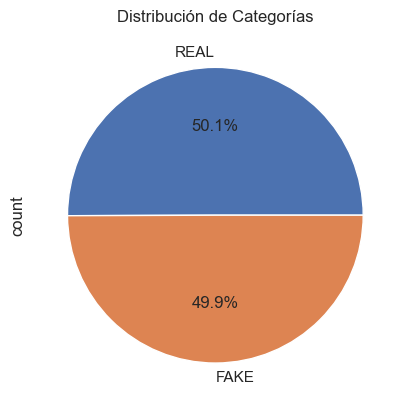

In [216]:
df_fake['fake'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribución de Categorías')
plt.show()

#### Nulos y valores atípicos.

No existen nulos en ninguna columna.

In [219]:
df_fake.isna().sum()

id      0
fake    0
dtype: int64

La columna 'Fake' consta únicamente de valores 'Fake' y 'Real', por lo cual vamos a analizar si hay algún valor atípico en la columna 'id' por si hubiera algún valor extraño.

In [221]:
df_fake.describe()

id
count   6335.000000
mean    5280.415627
std     3038.503953
min        2.000000
25%     2674.500000
50%     5271.000000
75%     7901.000000
max    10557.000000

Vemos que la distribución es normal y que los valores mínimos y máximos concuerdan con los valores de las columnas 'id' del resto de tablas.

In [223]:
df_fake[df_fake['id'] % 1 != 0] # Comprobamos que no hay valores decimales en la columna 'id'

Empty DataFrame
Columns: [id, fake]
Index: []

#### Resumen

**Como resumen de este análisis podemos sacar:**


* La tabla df_fake consta de 6335 filas y 2 columnas, "id" de tipo int64 y "fake" de tipo object.
* La columna "id" no tiene valores duplicados ni nulos.
* La columna "id" tiene un rango entre el 2 y el 10557.
* La columna "fake" no tiene valores nulos.
* La columna "fake" consta de los valores únicos 'FAKE' y 'REAL'.
* El 50,06% (3171) de las noticias son Reales y el 49,94% (3164) de las noticias son fake.

### EDA tabla df_info

In [227]:
df_info.head()

id         autor
0   8476    Marcus Liu
1  10294     Lily Wang
2   3608    Nora Patel
3  10142     Avery Kim
4    875  Daniel Patel

#### Tipo de datos

La tabla df_info consta de dos columnas, la primera llamada 'id' representa los valores únicos que identifican a la noticia y la segunda columna llamada 'autor' contiene el nombre de los autores de cada noticia.

In [230]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6335 non-null   int64 
 1   autor   6069 non-null   object
dtypes: int64(1), object(1)
memory usage: 99.1+ KB


La columna 'id' debería contener únicamente valores numéricos, por lo cual el tipo de dato está bien asignado. De igual forma, la columna autor está definida con el tipo de dato correcto, ya que es de tipo object.

#### Dimensiones

In [233]:
print(f'La tabla df_info consta de {df_info.shape[0]} filas y {df_info.shape[1]} columnas.')

La tabla df_info consta de 6335 filas y 2 columnas.


#### Duplicados

Comprobamos que no hay duplicados en la columna 'id'

In [236]:
duplicados_id = df_info['id'].duplicated()
print(f"Duplicados en 'id': {duplicados_id.sum()}")

Duplicados en 'id': 0


Ahora vamos a ver los autores únicos y el número de noticias que ha publicado cada uno.

In [238]:
print(f" La columna 'autor' esta compuesta por {df_info['autor'].nunique(dropna = False)} autores incluyendo los valores nulos")

 La columna 'autor' esta compuesta por 37 autores incluyendo los valores nulos


In [239]:
valores_unicos = df_info['autor'].unique()
print(valores_unicos)

['Marcus Liu' 'Lily Wang' 'Nora Patel' 'Avery Kim' 'Daniel Patel'
 'Noah Khan' 'Victoria Singh' 'Owen Rodriguez' 'Isabella Nguyen'
 'Ella Sharma' 'Ethan Hayes' 'Amelia Rivera' 'Alexander Lee'
 'Madison Wong' 'Lucas Kim' -1 'Grace Liu' 'Emily Parker' '' 'Jacob Gupta'
 'Xavier Chang' 'Samantha Chen' 'Sophie Chen' 'Caleb Shah'
 'Gabriel Santos' 'Aria Shah' None 'Chloe Nguyen' 'Ava Murphy'
 'Logan Wong' 'William Kumar' 'Olivia Kumar' 'Mia Gupta' 'Michael Sharma'
 'Maxwell Rivera' 'Zoe Lee' 'Benjamin Singh']


Ahora vamos a visualizar un gráfico con el número de noticias que publica cada autor.

In [241]:
conteo_valores = df_info['autor'].value_counts(dropna=False).reset_index(name='num_noticias').sort_values(by='num_noticias',ascending=True)
conteo_valores['autor'] = conteo_valores['autor'].replace([''], 'Autores en blanco')# rellenamos los campos vacios con 'Autores en blanco'
conteo_valores['autor'] = conteo_valores['autor'].fillna('Autores nulos') # rellenamos los nulos con 'Autores nulos'
conteo_valores['autor'] = conteo_valores['autor'].replace([-1], 'valor: -1')

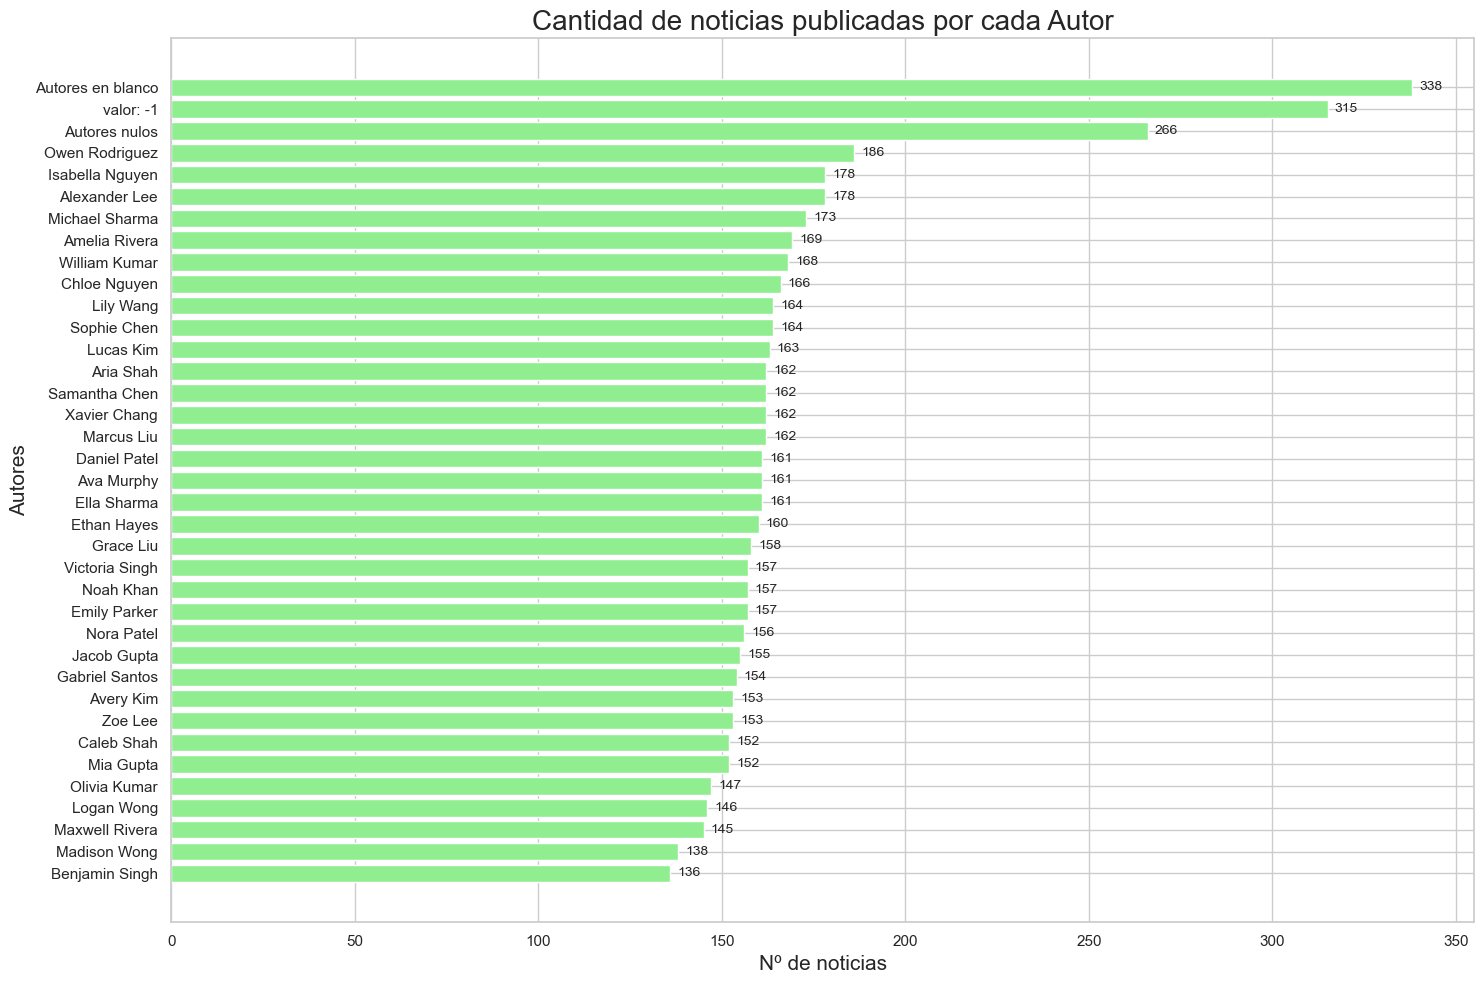

In [242]:
plt.figure(figsize=(15, 10))
bars = plt.barh(conteo_valores['autor'], conteo_valores['num_noticias'], color='lightgreen')


for bar in bars:
    width = bar.get_width() 
    plt.text(width + 2, bar.get_y() + bar.get_height() / 2,
             str(width), ha='left', va='center', fontsize=10)


plt.title('Cantidad de noticias publicadas por cada Autor', fontsize=20)
plt.ylabel('Autores', fontsize=15)
plt.xlabel('Nº de noticias', fontsize=15)
plt.xticks(rotation=0)


plt.tight_layout()
plt.show()

#### Nulos y valores atípicos

Vamos a comprobar los valores nulos y atípicos que tenemos en nuestro DF

In [245]:
df_info.isnull().sum()

id         0
autor    266
dtype: int64

A primera vista solo tenemos nulos en la columna 'autor' sin embargo, vamos a comprobar si hay algún valor extraño en nuestra columna 'id'

In [247]:
df_info.describe() #vemos como se distribuye la columna 'id'

id
count   6335.000000
mean    5280.415627
std     3038.503953
min        2.000000
25%     2674.500000
50%     5271.000000
75%     7901.000000
max    10557.000000

In [248]:
df_info[df_info['id'] % 1 != 0] # comprobamos si la columna 'id' contiene algun valor decimal.

Empty DataFrame
Columns: [id, autor]
Index: []

Hemos comprobado que en la columna 'id' no hay valores decimales y que su distribución es igual que la del resto de columnas 'id'

Como hemos visto antes, en la columna 'autor' hay valores nulos y atípicos.

In [251]:
df_info['autor'].unique()# visualizamos los valores unicos en la columna 'autor'

array(['Marcus Liu', 'Lily Wang', 'Nora Patel', 'Avery Kim',
       'Daniel Patel', 'Noah Khan', 'Victoria Singh', 'Owen Rodriguez',
       'Isabella Nguyen', 'Ella Sharma', 'Ethan Hayes', 'Amelia Rivera',
       'Alexander Lee', 'Madison Wong', 'Lucas Kim', -1, 'Grace Liu',
       'Emily Parker', '', 'Jacob Gupta', 'Xavier Chang', 'Samantha Chen',
       'Sophie Chen', 'Caleb Shah', 'Gabriel Santos', 'Aria Shah', None,
       'Chloe Nguyen', 'Ava Murphy', 'Logan Wong', 'William Kumar',
       'Olivia Kumar', 'Mia Gupta', 'Michael Sharma', 'Maxwell Rivera',
       'Zoe Lee', 'Benjamin Singh'], dtype=object)

In [252]:
print(f'La columna "autor" contiene {df_info['autor'].nunique(dropna=False)} valores unicos')

La columna "autor" contiene 37 valores unicos


In [253]:
print(f'La columna "autor" tiene {df_info['autor'].isnull().sum()} valores nulos')

La columna "autor" tiene 266 valores nulos


In [254]:
print(f'La columna "autor" contiene {(df_info['autor'] == '').sum()} valores vacios')

La columna "autor" contiene 338 valores vacios


In [255]:
print(f'La columna "autor" contiene {(df_info['autor'] == -1).sum()} valores -1')

La columna "autor" contiene 315 valores -1


Una vez tenemos localizados los nulos y valores atípicos, vamos a tratarlos, sustituyéndolos por la palabra 'Desconocido'

In [257]:
df_info['autor'] = df_info['autor'].replace('','Desconocido')

In [258]:
df_info['autor'] = df_info['autor'].replace(-1,'Desconocido')

In [259]:
df_info['autor'] = df_info['autor'].fillna('Desconocido')

#### Analisis

Vamos a analizar el número de noticias que publica cada autor

In [262]:
noticias_autor = df_info['autor'].value_counts(dropna=False).reset_index(name='num_noticias').sort_values(by='num_noticias',ascending=True)

In [263]:
noticias_autor.describe()

num_noticias
count     35.000000
mean     181.000000
std      128.836878
min      136.000000
25%      153.500000
50%      161.000000
75%      164.000000
max      919.000000

El 75% de los autores han publicado entre 136 y 164 cada uno.

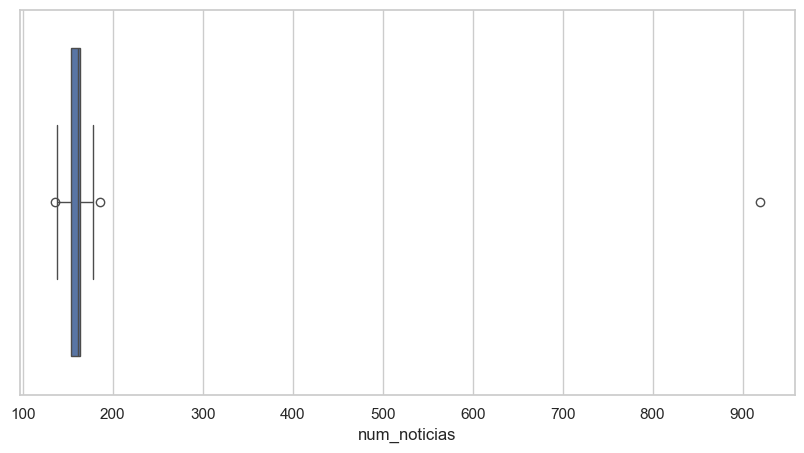

In [265]:
plt.figure(figsize=(10,5))
sns.boxplot(x=noticias_autor['num_noticias'])
plt.show()

In [266]:
print(f'El autor que mas publica noticias es {conteo_valores.iloc[33,0]} con un total de {conteo_valores.iloc[33,1]} noticias')

El autor que mas publica noticias es Owen Rodriguez con un total de 186 noticias


In [267]:
print(f'El autor que menos publica noticias es {conteo_valores.iloc[0,0]} con un total de {conteo_valores.iloc[0,1]} noticias')

El autor que menos publica noticias es Benjamin Singh con un total de 136 noticias


#### Resumen.

**Como resumen de este análisis podemos sacar:**


* La tabla df_info consta de 6335 filas y 2 columnas, la columna "id" de tipo int64 y la columna "autor" de tipo object.
* La columna "id" no tiene valores duplicados.
* La columna "id" está entre el rango 2 y 10557
* La columna "autor" contiene 338 valores en blanco, 315 valores "-1" y 266 valores nulos
* Después de limpiar la tabla, la columna "autor" está compuesta por 35 autores únicos.
* El 75% de los autores han publicado entre 136 y 164 cada uno.
* La media de noticias publicadas por autor son 161.
* Hay 919 noticias con autor "Desconocido"
* El autor que más publica noticias es Owen Rodríguez, con un total de 186 noticias.
* El autor que menos publica noticias es Benjamín Singh con un total de 136 noticias
 

### EDA tabla df_fuente

In [271]:
df_fuente.head()

id              fuente
0   8476  The Daily Dispatch
1  10294    Insider Insights
2   3608        Daily Beacon
3  10142           The Pulse
4    875        Morning Star

#### Tipos de datos

La tabla df_fuente contiene la columna 'id' que representa el identificador unico de la noticia y la columna 'fuente' que contiene el periódico o página web que publica el artículo bajo su firma. 

In [274]:
df_fuente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6335 non-null   int64 
 1   fuente  6335 non-null   object
dtypes: int64(1), object(1)
memory usage: 99.1+ KB


A primera vista las columnas tienen el tipo de columna correctamente asignado ya que la columna 'id' representa la clave id de cada noticia y la columna 'fuente' refleja la fuente de cada noticia.

#### Dimensiones

Nuestra tabla consta de 6335 filas y 2 columnas.

In [278]:
df_fuente.shape

(6335, 2)

La columna 'id' tiene un valor minimo de 2 y maximo de 10557

In [280]:
df_fuente['id'].min()

2

In [281]:
df_fuente['id'].max()

10557

 La columna 'fuente' tiene un minimo de 8 caracteres y un maximo de 19

In [283]:
num_caracteres = df_fuente['fuente'].apply(len)
num_max_caracteres = df_fuente['fuente'].apply(len).max()
num_min_caracteres = df_fuente['fuente'].apply(len).min()

print(f"El numero de caracteres minimo de la columna fuente es {num_min_caracteres}")
print(f"El numero de caracteres maximo de la columna fuente es {num_max_caracteres}")

El numero de caracteres minimo de la columna fuente es 8
El numero de caracteres maximo de la columna fuente es 19


Visualizamos un ejemplo del maximo y minio de caracteres

In [285]:
df_fuente[df_fuente['fuente'].apply(len)==num_max_caracteres].head()

id               fuente
23   3300  Voice of the Nation
42   5955  Voice of the Nation
80   4134  Voice of the Nation
103  2974  Voice of the Nation
106  5530  Voice of the Nation

In [286]:
df_fuente[df_fuente['fuente'].apply(len)==num_min_caracteres].head()

id    fuente
41    431  Newsline
51   4377  Newsline
160  4354  Newsline
168  8918  Newsline
183  6851  Newsline

#### Duplicados

Comprobamos los duplicados en cada columna

In [289]:
# Ver si hay duplicados en 'id'

duplicados_id = df_fuente['id'].duplicated()
print(f"Duplicados en 'id': {duplicados_id.sum()}")

Duplicados en 'id': 0


In [290]:
# Ver si hay duplicados en 'fuente'

duplicados_id = df_fuente['fuente'].duplicated()
print(f"Duplicados en 'fuente': {duplicados_id.sum()}")

Duplicados en 'fuente': 6302


Es normal que haya duplicados en la columna 'fuente' ya que entendemos que una misma fuente puede publicar multiples noticias

#### Nulos y valores atípicos

Hacemos una comprobación de los valores nulos de cada columna.

In [294]:
df_fuente.isna().sum()

id        0
fuente    0
dtype: int64

Vemos que ninguna de las dos columnas contienen valores nulos

Ahora vamos a comprobar si algun campo de la columna fuente contiene numeros.

In [297]:
print(f'Un total de {df_fuente['fuente'].str.contains(r'\d', na=False).sum()} campos contiene valores numericos')

Un total de 0 campos contiene valores numericos


#### Analisis

Ahora primero vamos a visulizar los valores unicos de la columna 'fuente'

In [300]:
valores_unicos = df_fuente['fuente'].unique()
print(valores_unicos)

['The Daily Dispatch' 'Insider Insights' 'Daily Beacon' 'The Pulse'
 'Morning Star' 'The Insight' 'National Courier' 'Global Gazette'
 'World News Network' 'Times Today' 'Evening Echo' 'Central Times'
 'The Chronicle' 'Frontline Times' 'The Reporter' 'The Observer'
 'Voice of the Nation' 'Star Sentinel' 'Urban News' 'Daily Digest'
 'Echo News' 'The Herald Tribune' 'Newsline' 'Press Pulse' 'City Times'
 'Metro News' 'Sunrise Chronicle' 'Capital Gazette' 'Express Tribune'
 'The Informer' 'Global Insight' 'Newsflash' 'City Beat']


In [301]:
print(f'Hay un total de {len(valores_unicos)} fuentes')

Hay un total de 33 fuentes


Luego vamos a ver el numero de veces que publica cada fuente

In [303]:
conteo_valores = df_fuente['fuente'].value_counts(dropna=False).reset_index().sort_values(by='count')
conteo_valores

fuente  count
32         The Observer    166
30      Express Tribune    172
31             Newsline    172
29        Star Sentinel    175
28           City Times    176
27      Frontline Times    176
26      Capital Gazette    178
25     Insider Insights    179
24        Central Times    179
23   The Herald Tribune    180
22         The Reporter    182
21         Daily Digest    182
20     National Courier    182
19            The Pulse    182
18         Daily Beacon    183
17         The Informer    183
16            Echo News    183
14       Global Insight    184
15       Global Gazette    184
13   World News Network    185
12            City Beat    187
11        The Chronicle    189
10         Morning Star    190
9            Urban News    190
8          Evening Echo    192
7             Newsflash    192
6   Voice of the Nation    196
5           Press Pulse    196
4    The Daily Dispatch    198
3            Metro News    211
2           Times Today    212
1     Sunrise Chronicle    215
0           The Insight    384

La fuente que menos publica es:

In [305]:
conteo_valores[conteo_valores['count']==(conteo_valores['count'].min())]

fuente  count
32  The Observer    166

La fuente que mas publica es:

In [307]:
conteo_valores[conteo_valores['count']==(conteo_valores['count'].max())]

fuente  count
0  The Insight    384

La media de publicaciones por fuente son casi 192 veces.

In [309]:
conteo_valores['count'].mean()

191.96969696969697

#### Resumen

**Como resumen de este análisis podemos sacar:**

* La tabla df_fuente consta de 6335 filas y 2 columnas, la columna "id" de tipo int64 y la columna "fuente" de tipo object.
* La columna "id" no tiene valores duplicados.
* No hay valores nulos en la tabla.
* La columna "id" está entre el rango 2 y 10557.
* La columna 'fuente' tiene un mínimo de 8 caracteres y un máximo de 19.
* Hay 33 fuentes diferentes.
* La fuente "The insight" es la fuente que más publica con un total de 384 noticias.
* La fuente "The observer" es la fuente que menos publica con un total de 166 noticias.
* La media de publicaciones por fuente son casi 192.

### EDA tabla df_metadatos

In [313]:
df_metadatos.head()

t_id visitas compartir duracion favorito
8476    8476  389073     55938      599     8008
10294  10294  239160     34348      216     7958
3608    3608   48853     43056      447     8145
10142  10142  710817     96927      184     1102
875      875  997280     74788      175     3299

#### Tipos de datos

La tabla df_metadatos está compuesta por 5 columnas que son:

* La columna 't_id' que representa el identificador único de cada noticia.  
* La columna 'visitas' que contiene el número de visualizaciones que ha recibido la noticia.  
* La columna 'compartir' que refleja el número de veces que se ha compartido el enlace de la noticia en redes sociales.  
* La columna 'duracion' que representa el tiempo de lectura del usuario.  
* La columna 'favorito' que nos dice el número de veces que un usuario ha marcado el artículo como favorito.

Vemos que todas las columnas tienen como tipo de columna object.

In [317]:
df_metadatos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6335 entries, 8476 to 4330
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   t_id       6335 non-null   object
 1   visitas    6333 non-null   object
 2   compartir  6320 non-null   object
 3   duracion   6335 non-null   object
 4   favorito   6223 non-null   object
dtypes: object(5)
memory usage: 555.0+ KB


Entendemos que todas las columnas deberían de ser numericas int, asi que procedemos a cambiarles el tipo.

In [319]:
df_metadatos['t_id']=df_metadatos['t_id'].astype('int64')         # la columna 't_id' la cambiamos a int64
df_metadatos['duracion']=df_metadatos['duracion'].astype('int64') # la columna 'duracion' la cambiamos a int64

Las tres columnas 'visitas','favorito' y 'compartir' no se pueden convertir como int de momento ya que contienen valores no numericos y/o nulos

In [321]:
# df_metadatos['visitas'].astype('int64')
# df_metadatos['favorito'].astype('int64')
# df_metadatos['compartir'].astype('int64')

#### Dimensiones

Nuestro Df de metadatos consta de 6335 filas y 5 columnas

In [324]:
df_metadatos.shape

(6335, 5)

#### Duplicados

Comprobamos que no hay duplicados en el DF.

In [327]:
duplicados_metadatos = df_metadatos.loc[df_metadatos.duplicated()]
duplicados_metadatos

Empty DataFrame
Columns: [t_id, visitas, compartir, duracion, favorito]
Index: []

#### Nulos y valores atípicos

Comprobamos los valores nulos que contienen nuestro DF en cada columna

In [330]:
nulos_metadatos = df_metadatos.isnull().sum().sort_values()

nulos_metadatos

t_id           0
duracion       0
visitas        2
compartir     15
favorito     112
dtype: int64

Ahora vamos a visualizar columna por columna los nulos y valores atípicos :

***Columna 'visitas'***

In [333]:
# valores nulos columna 'visitas'

df_metadatos[(df_metadatos['visitas'].isnull())]

t_id visitas compartir  duracion favorito
4759  4759     NaN   16294.0      -416   5099.0
8626  8626     NaN   81291.0         2   1313.0

In [334]:
# valores atípicos columna 'visitas'

atipico_visitas = df_metadatos[df_metadatos['visitas'].str.contains(r'\D', na=False)]
atipico_visitas

t_id visitas compartir  duracion favorito
10340  10340     err     83728       191     1112
6902    6902     err     72978       102     1028
808      808     err     64919       121     3569
4845    4845     err     42394      -289     3903
4141    4141     err      2886       166     5296

Vemos que la columna 'visitas' contiene 5 registros con el valor 'err' que podemos deducir que se trata de un error por lo cual podríamos sustituirlo.

***columna 'compartir'***

In [337]:
# valores nulos columna 'compartir'

df_metadatos[(df_metadatos['compartir'].isnull())]

t_id   visitas compartir  duracion favorito
7114    7114  203060.0       NaN       265   8827.0
8927    8927  788131.0       NaN        80   6576.0
416      416  576645.0       NaN       298   6277.0
10205  10205  703131.0       NaN       130   1457.0
3572    3572  413895.0       NaN       337   4945.0
5631    5631  846409.0       NaN       362   4832.0
403      403  215729.0       NaN       290   1900.0
9235    9235  569908.0       NaN       416   8896.0
4791    4791   90102.0       NaN       427   4700.0
5883    5883  193937.0       NaN       251    278.0
10551  10551  729229.0       NaN       185   4582.0
8313    8313  267329.0       NaN       478   5918.0
7770    7770  705609.0       NaN        12   6465.0
3346    3346  542548.0       NaN       961   1025.0
7627    7627  604802.0       NaN       276   1725.0

In [338]:
# valores atípicos columna 'compartir'

atipico_compartir = df_metadatos[df_metadatos['compartir'].str.contains(r'\D', na=False)]
atipico_compartir

t_id visitas compartir  duracion favorito
1770  1770  619833      null      -106     6311
4096  4096  494159      null       553     6674
7869  7869  647688      null       581     5520
887    887  199555      null      -100     2603
7059  7059  486707      null       174     9934
3990  3990  884460      null       317     None
9085  9085  704583      null       502     3914
3489  3489  993896      null       115     5268
2543  2543  104004      null        88     None
8673  8673  109612      null       169     9694
8991  8991  865231      null       325      208
7836  7836  856282      null       133     5521

Vemos que la columna 'compartir' contiene 12 registros con la palabra 'null' lo que nos dice que son valores nulos y podriamos sustituirlos por NaN.

***Columna 'favorito'***

In [341]:
# valores nulos columna 'favorito'

df_metadatos[(df_metadatos['favorito'].isnull())]

t_id   visitas compartir  duracion favorito
778    778  827698.0   45264.0       371      NaN
4377  4377   18785.0   26639.0       207      NaN
5521  5521  391763.0    7357.0       400      NaN
1641  1641  663741.0   26580.0       517      NaN
9554  9554   45163.0   97058.0       548      NaN
...    ...       ...       ...       ...      ...
2262  2262  653278.0   61319.0       194      NaN
301    301  441767.0   82719.0       276      NaN
9725  9725  528827.0   93529.0       524      NaN
142    142  664853.0   70767.0       287      NaN
6935  6935  914330.0   10177.0       260      NaN

[112 rows x 5 columns]

In [342]:
# valores atípicos columna 'favorito'

atipico_favorito = df_metadatos[df_metadatos['favorito'].str.contains(r'\D', na=False)]
atipico_favorito

t_id visitas compartir  duracion favorito
691      691  928651     36172       235     favx
10092  10092  357887     78674       141     favx
2115    2115  801341     42202       138     favx
9991    9991  322875     71092       419     favx
5926    5926  808332     94964       529     favx
...      ...     ...       ...       ...      ...
4036    4036  576084     67959       606     favx
5632    5632  959563     21303        49     favx
10312  10312  716911     38184       194     favx
5709    5709  542086     38557       151     favx
8053    8053  811997     64954      -221     favx

[122 rows x 5 columns]

En el caso de la columna 'favorito' vemos que hay 122 registros con valores no numericos. Al no poder visualizarlos todos vamos a comprobar que todos los valores no numericos sean iguales, en este caso 'favx'

In [344]:
print(f'Los valores no numericos en la columna "favorito" son: {atipico_favorito['favorito'].unique()}')

Los valores no numericos en la columna "favorito" son: ['favx']


Vamos a comprobar si hay filas con mas de un campo con caracteres no numericos

In [346]:
favorito_no_numerico = df_metadatos['favorito'].str.contains(r'\D', na=False)   # filtro para detectar valores no numerico en columna 'favorito'
compartir_no_numerico = df_metadatos['compartir'].str.contains(r'\D', na=False) # filtro para detectar valores no numerico en columna 'comparti'
visitas_no_numerico  = df_metadatos['visitas'].str.contains(r'\D', na=False)    # filtro para detectar valores no numerico en columna 'visitas'

df_metadatos[(favorito_no_numerico & compartir_no_numerico)|(compartir_no_numerico & visitas_no_numerico)|(visitas_no_numerico & favorito_no_numerico)]

Empty DataFrame
Columns: [t_id, visitas, compartir, duracion, favorito]
Index: []

Una vez ya tenemos bien identificados y analizados los caracteres no numéricos de nuestras columnas, sabemos por qué nos daba error al principio al intentar transformar nuestras columnas de tipo object a int.

Sabiendo esto vamos a transformar nuestras 3 columnas en tipo numerico forzando los valores no numericos a NaN.

In [349]:
df_metadatos['visitas'] = pd.to_numeric(df_metadatos['visitas'], errors='coerce').astype('float64')

In [350]:
df_metadatos['compartir'] = pd.to_numeric(df_metadatos['compartir'], errors='coerce').astype('float64')

In [351]:
df_metadatos['favorito'] = pd.to_numeric(df_metadatos['favorito'], errors='coerce').astype('float64')

Sin embargo no nos deja transformar las columnas en int, solo en float, asi que vamos buscar si estas columnas contienen algun valor decimal.

In [353]:
columns = ['duracion','visitas','compartir','favorito']

for column in columns:
    print(f'Campos de la columna {column} con valores decimales:')
    df_decimales = df_metadatos[(df_metadatos[column]%1!=0) & (df_metadatos[column].notna())]
    print(df_decimales)
    print(f'Los valores decimales unicos en la columna {column} son {df_decimales[column].unique()}')
    print(f'Total filas {df_decimales.shape[0]}')
    print('-------------------------------------------------')


Campos de la columna duracion con valores decimales:
Empty DataFrame
Columns: [t_id, visitas, compartir, duracion, favorito]
Index: []
Los valores decimales unicos en la columna duracion son []
Total filas 0
-------------------------------------------------
Campos de la columna visitas con valores decimales:
      t_id  visitas  compartir  duracion  favorito
9043  9043      3.1    97863.0        30      0.73
Los valores decimales unicos en la columna visitas son [3.1]
Total filas 1
-------------------------------------------------
Campos de la columna compartir con valores decimales:
      t_id   visitas  compartir  duracion  favorito
2909  2909   70070.0       72.5        24    3836.0
1118  1118  869494.0       72.5       -21    1425.0
756    756  880455.0       72.5       561    2160.0
1760  1760  266305.0       72.5       -78    8261.0
9321  9321  660612.0       72.5       449    3973.0
2412  2412  171379.0       72.5       -70    8943.0
4947  4947  832844.0       72.5         4    

Vemos que:

La columna 'visitas' tiene un campo con el valor 3.1

La columna 'compartir' tiene 12 campos con el valor 72.5

La columna 'visitas' tiene 126 campos con el valor 0.73



Siguiendo con la busquedad de valores atípicos vamos a ver si nuestra tabla de metadatos contiene valores negativos.

In [356]:
columns = ['t_id','visitas','compartir','duracion','favorito']

for column in columns:
    x = df_metadatos[df_metadatos[column]< 0]
    print('------------------------------------------------')
    print(f'La columna {column} tiene un total de {x.shape[0]} valores negativos.')
    print(' ')
    print(x)


------------------------------------------------
La columna t_id tiene un total de 0 valores negativos.
 
Empty DataFrame
Columns: [t_id, visitas, compartir, duracion, favorito]
Index: []
------------------------------------------------
La columna visitas tiene un total de 1 valores negativos.
 
      t_id  visitas  compartir  duracion  favorito
9877  9877     -7.0    65411.0       473     231.0
------------------------------------------------
La columna compartir tiene un total de 10 valores negativos.
 
      t_id   visitas  compartir  duracion  favorito
1524  1524  258397.0       -1.0      -111    9697.0
6220  6220   46664.0       -1.0       439    4326.0
1870  1870   22540.0       -1.0       151    8000.0
9475  9475  572873.0       -1.0       480    9129.0
3353  3353  785951.0       -1.0       133    4908.0
7852  7852  538462.0       -1.0       261    1574.0
2901  2901  839420.0       -1.0       239    7671.0
1288  1288  230501.0       -1.0       339    1066.0
8408  8408  269830.0 

Descubrimos que:

La columna 'visitas' tiene 1 valor negativo.

La columna 'compartir' tiene 10 valores negativos.

La columna 'duracion' tiene 693 valores negativos.

***Sustituir los valores nulos y atípicos***

Vamos a comparar como varían las diferentes medidas estadísticas de cada columna al sustituir los valores nulos y atípicos.

In [360]:
# Medidas estadisticas originales

df_metadatos.describe()

t_id        visitas     compartir     duracion     favorito
count   6335.000000    6328.000000   6308.000000  6335.000000  6101.000000
mean    5280.415627  502911.179535  50023.781864   239.958485  4896.665134
std     3038.503953  290831.341567  29063.622118   198.703748  2945.809362
min        2.000000      -7.000000     -1.000000  -512.000000     0.730000
25%     2674.500000  250373.500000  24761.750000   108.500000  2337.000000
50%     5271.000000  507938.500000  50616.000000   241.000000  4900.000000
75%     7901.000000  756118.000000  74968.750000   373.000000  7403.000000
max    10557.000000  999864.000000  99951.000000   961.000000  9998.000000

In [361]:
# Reemplazamos los valores negativos del df por NaN

df_copia_metadatos = df_metadatos
df_copia_metadatos.loc[df_copia_metadatos["duracion"] < 0, "duracion"] = np.nan
df_copia_metadatos.loc[df_copia_metadatos["visitas"] < 0, "visitas"] = np.nan
df_copia_metadatos.loc[df_copia_metadatos["compartir"] < 0, "compartir"] = np.nan


# Reemplazamos los valores decimales del df por NaN

df_copia_metadatos[df_copia_metadatos % 1 != 0] = np.nan

In [362]:
# Diferencia estadistica al rellenar los valores nulos con la media de cada columna numérica

round(df_copia_metadatos.fillna(df_copia_metadatos.mean()).describe() - df_metadatos.describe()),2


(       t_id  visitas  compartir  duracion  favorito
 count   0.0      9.0       49.0     693.0     360.0
 mean    0.0     -0.0        0.0       0.0      -0.0
 std     0.0   -207.0     -112.0      -9.0     -83.0
 min     0.0      0.0        0.0       0.0       0.0
 25%     0.0    144.0      222.0      13.0     134.0
 50%     0.0   -910.0     -351.0      15.0      -4.0
 75%     0.0   -493.0     -238.0     -19.0    -152.0
 max     0.0      0.0        0.0       0.0       0.0,
 2)

In [363]:
# Diferencia estadistica al rellenar los valores nulos con la mediana de cada columna numérica

round(df_copia_metadatos.fillna(df_copia_metadatos.median()).describe() - df_metadatos.describe()),2

(       t_id  visitas  compartir  duracion  favorito
 count   0.0      9.0       49.0     693.0     360.0
 mean    0.0      7.0        4.0      -2.0       0.0
 std     0.0   -207.0     -112.0      -9.0     -83.0
 min     0.0      0.0        0.0       0.0       0.0
 25%     0.0    144.0      222.0      13.0     134.0
 50%     0.0      0.0        0.0       0.0       0.0
 75%     0.0   -493.0     -238.0     -19.0    -152.0
 max     0.0      0.0        0.0       0.0       0.0,
 2)

Finalmente, vemos que sustituyendo los Nan por la mediana influimos menos en las estadísticas de los datos, así que, realizamos la transformación en nuestro df_metadatos original.

In [365]:
# Reemplazamos los valores negativos del df por NaN

df_metadatos.loc[df_metadatos["duracion"] < 0, "duracion"] = np.nan
df_metadatos.loc[df_metadatos["visitas"] < 0, "visitas"] = np.nan
df_metadatos.loc[df_metadatos["compartir"] < 0, "compartir"] = np.nan


# Reemplazamos los valores decimales del df por NaN

df_metadatos[df_metadatos % 1 != 0] = np.nan


# Reemplazamos los valores Nan por la mediana de cada columna

df_metadatos.fillna(df_metadatos.median(), inplace = True)


#### Analisis

Primero haremos un analisis de las principales estadisticas descriptivas de la tabla y como se distribuyen sus valores.

In [368]:
df_metadatos.describe().round(2)

t_id    visitas  compartir  duracion  favorito
count   6335.00    6335.00    6335.00   6335.00   6335.00
mean    5280.42  503077.18   50202.80    280.71   5000.14
std     3038.50  290533.20   28851.12    154.91   2805.41
min        2.00     184.00      13.00      0.00      1.00
25%     2674.50  250870.50   25283.50    171.00   2638.50
50%     5271.00  507996.00   50726.00    267.00   5004.00
75%     7901.00  755669.00   74869.00    373.00   7305.50
max    10557.00  999864.00   99951.00    961.00   9998.00

array([[<Axes: title={'center': 't_id'}>,
        <Axes: title={'center': 'visitas'}>],
       [<Axes: title={'center': 'compartir'}>,
        <Axes: title={'center': 'duracion'}>],
       [<Axes: title={'center': 'favorito'}>, <Axes: >]], dtype=object)

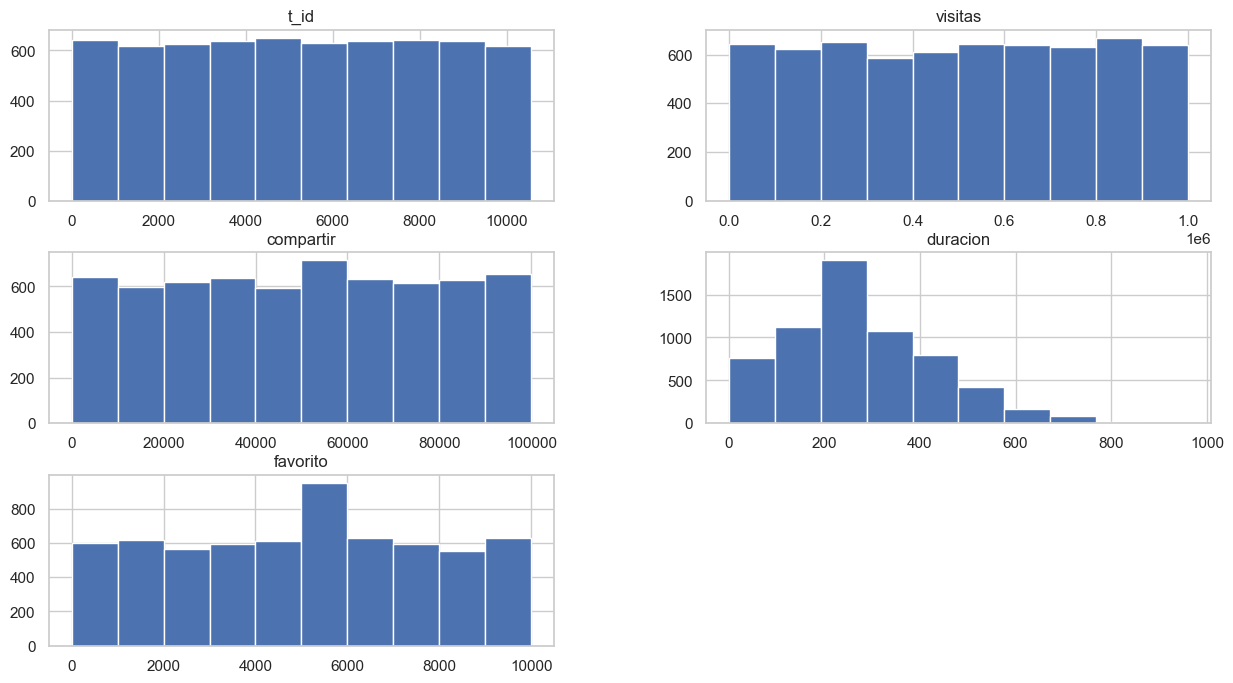

In [369]:
df_metadatos.hist(figsize=(15,8))

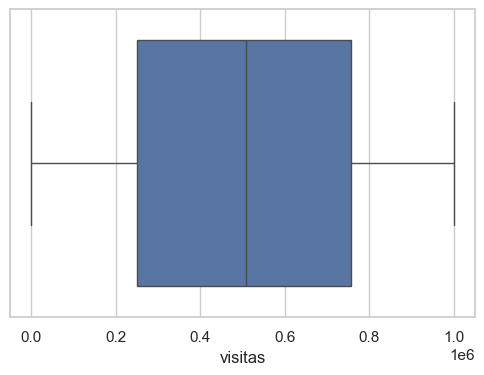

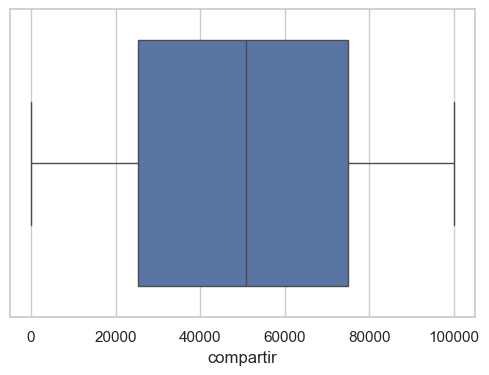

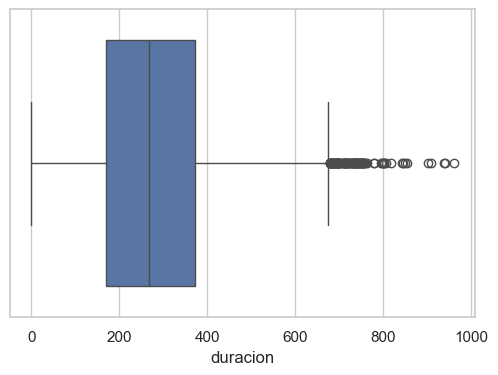

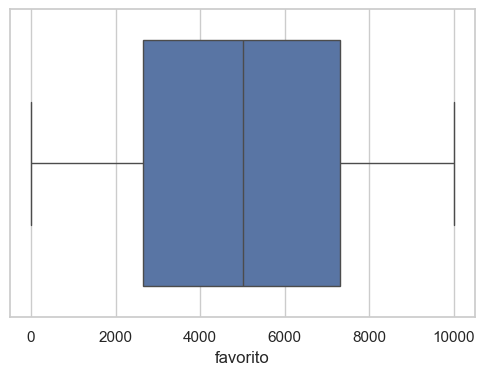

In [370]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_metadatos["visitas"])
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df_metadatos["compartir"])
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df_metadatos["duracion"])
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df_metadatos["favorito"])
plt.show()

In [371]:
df_metadatos.corr()

t_id   visitas  compartir  duracion  favorito
t_id       1.000000 -0.002073  -0.007583 -0.011119 -0.012684
visitas   -0.002073  1.000000   0.002443 -0.009452  0.005621
compartir -0.007583  0.002443   1.000000  0.010140  0.019642
duracion  -0.011119 -0.009452   0.010140  1.000000 -0.002112
favorito  -0.012684  0.005621   0.019642 -0.002112  1.000000

Vemos de manera más visual que las variables no tienen correlación. 

<Axes: >

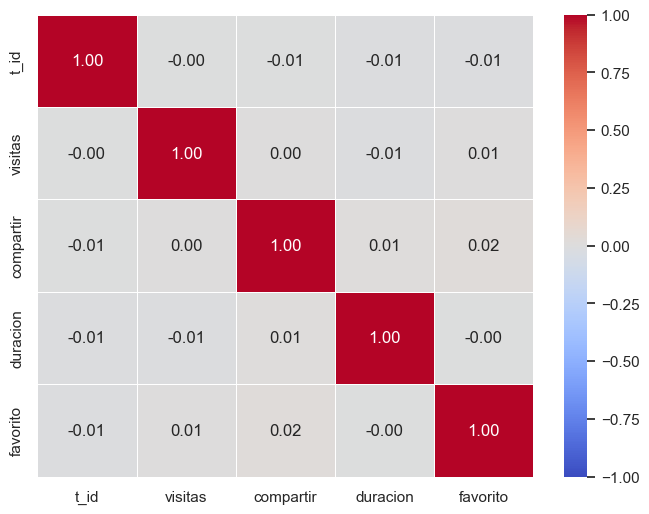

In [373]:
corr_metadatos = df_metadatos.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_metadatos, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

#### Resumen

**Como resumen de este análisis podemos sacar:**

* La tabla df_metadatos está compuesta por 6335 filas y 5 columnas: "t_id", "visitas", "compartir", "duración", "favorito"  de tipo int64 todas.
* Las columnas "t_id" y "duración" no tenían valores nulos.
* La columna "visitas" tenía 2 valores nulos, 5 registros 'err', 1 valor decimal y 1 valor negativo.
* La columna "compartir" tenía 15 valores nulos, 12 registros 'null', 12 valores decimales y 10 valores negativos.
* La columna "favorito" tenía 112 valores nulos, 122 registros 'favx' y 126 valores decimales.
* La columna "duración" tenía 693 valores negativos.

### EDA tabla df_pais_idioma

In [377]:
df_pais_idioma

id           pais   idioma
0      8476  United States  English
1     10294     Bangladesh  English
2      3608       Tanzania  English
3     10142       Thailand  English
4       875          Kenya  English
...     ...            ...      ...
6330   4490     Bangladesh  English
6331   8062   South Africa  English
6332   8622          China  English
6333   4021        Ukraine  English
6334   4330         Uganda  English

[6335 rows x 3 columns]

#### Tipos de datos

La tabla df_pais_idioma contiene la columna 'id' que representa el identificador unico de la noticia, la columna 'pais' que contiene el país donde se publica la noticia y por último la columna 'idioma' que refleja el idioma en el que se redacta la noticia.

Comprobamos que las 3 columnas son de tipo object cuando la columna 'id' debería ser numérica.

In [381]:
df_pais_idioma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6335 non-null   object
 1   pais    6335 non-null   object
 2   idioma  6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


Hacemos la conversión correspondiente.

In [383]:
df_pais_idioma['id']= pd.to_numeric(df_pais_idioma['id'])

#### Dimensiones

In [385]:
print(f'Nuestra tabla consta de {df_pais_idioma.shape[0]} filas y {df_pais_idioma.shape[1]} columnas.')

Nuestra tabla consta de 6335 filas y 3 columnas.


Vamos a analizar el número de caracteres de nuestras columnas de texto.

In [387]:
#Rango de la columna pais

longitud_pais = df_pais_idioma['pais'].apply(len)

print(f"El numero de caracteres maximo de la columna pais es {longitud_pais.max()}")
print(f"El numero de caracteres minimo de la columna pais es {longitud_pais.min()}")

El numero de caracteres maximo de la columna pais es 14
El numero de caracteres minimo de la columna pais es 4


In [388]:
#Rango de la columna idioma

longitud_idioma = df_pais_idioma['idioma'].apply(len)

print(f"El numero de caracteres maximo de la columna idioma es {longitud_idioma.max()}")
print(f"El numero de caracteres minimo de la columna idioma es {longitud_idioma.min()}")

El numero de caracteres maximo de la columna idioma es 7
El numero de caracteres minimo de la columna idioma es 7


#### Duplicados y valores atípicos.

Visualizamos los valores únicos de nuestra columna 'pais' e 'idioma'.

In [391]:
df_pais_idioma['pais'].unique() # valores unicos de la columna 'pais'

array(['United States', 'Bangladesh', 'Tanzania', 'Thailand', 'Kenya',
       'Germany', 'China', 'Mexico', 'Philippines', 'Russia', 'Indonesia',
       'Vietnam', 'Egypt', 'India', 'Myanmar', 'Sudan', 'Spain', 'Italy',
       'Japan', 'Ethiopia', 'Iran', 'Pakistan', 'France', 'Algeria',
       'Uganda', 'Ukraine', 'Turkey', 'Brazil', 'South Africa',
       'Colombia', 'United Kingdom', 'Argentina', 'DR Congo', 'Nigeria',
       'South Korea'], dtype=object)

In [392]:
print(f'La columna "pais" está formada por {df_pais_idioma['pais'].nunique()} paises únicos')

La columna "pais" está formada por 35 paises únicos


Comprobamos que la columna 'idioma' solo consta del valor unico 'English'.

In [394]:
df_pais_idioma['idioma'].unique() # valores unicos de la columna 'idioma'

array(['English'], dtype=object)

Nos aseguramos que no hay filas duplicadas.

In [396]:
duplicados_idiomapais = df_pais_idioma.loc[df_pais_idioma.duplicated()]
duplicados_idiomapais

Empty DataFrame
Columns: [id, pais, idioma]
Index: []

#### Nulos

Hacemos la comprobación de nulos para ver que no hay ningun nulo en la tabla.

In [399]:
df_pais_idioma.isnull().sum()

id        0
pais      0
idioma    0
dtype: int64

#### Análisis

Ahora vamos a ver cuantas veces se repite cada pais en la columna 'pais'

In [402]:
apariciones_cada_pais = df_pais_idioma.groupby('pais')['idioma'].count().reset_index(name='Nº noticias publicadas').sort_values(by='Nº noticias publicadas')

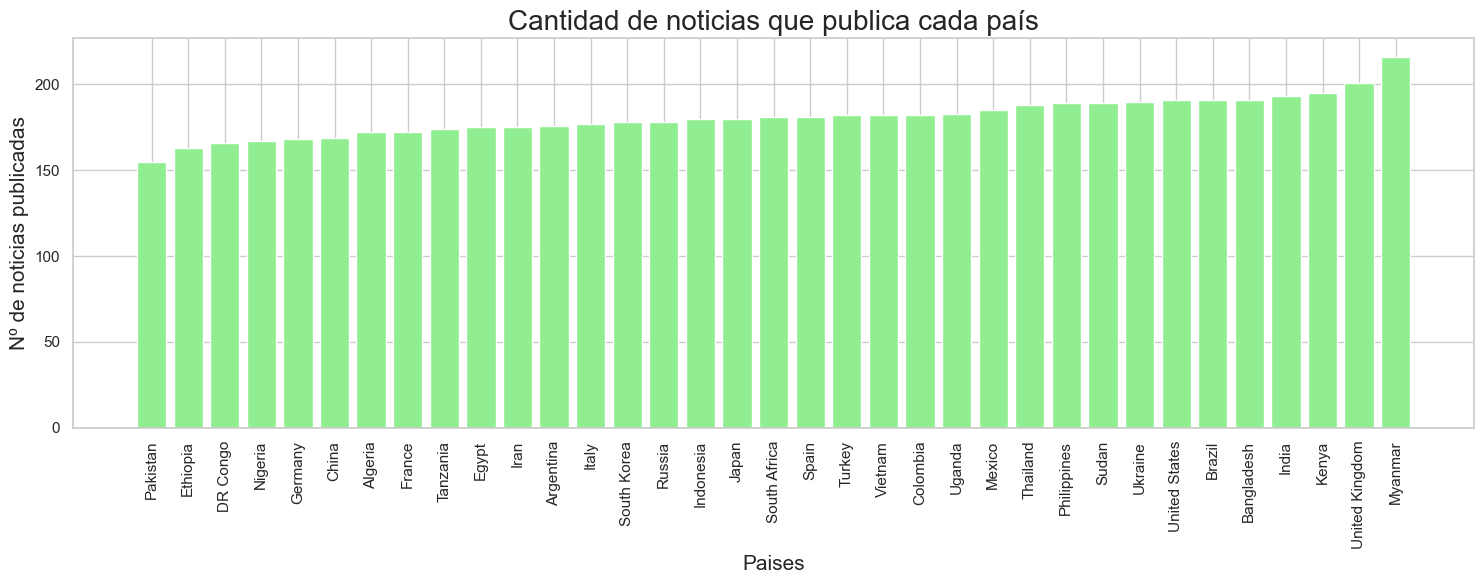

In [403]:
plt.figure(figsize=(15, 6))
plt.bar(apariciones_cada_pais['pais'], apariciones_cada_pais['Nº noticias publicadas'], color='lightgreen')


plt.title('Cantidad de noticias que publica cada país',fontsize=20)
plt.xlabel('Paises',fontsize=15)
plt.ylabel('Nº de noticias publicadas',fontsize=15)
plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()

Podemos comprobar que el pais que mas noticias publica es Myanmar y el que menos Pakistan.

In [405]:
apariciones_cada_pais[apariciones_cada_pais['pais']=='Myanmar'].sum() # Numero de noticias publicadas por Myanmar

pais                      Myanmar
Nº noticias publicadas        216
dtype: object

In [406]:
apariciones_cada_pais[apariciones_cada_pais['pais']=='Pakistan'].sum() # Numero de noticias publicadas por Pakistan

pais                      Pakistan
Nº noticias publicadas         155
dtype: object

Revisamos las estadisticas basicas de la columna que refleja el numero de noticias publicadas por cada país.

In [408]:
apariciones_cada_pais['Nº noticias publicadas'].describe()

count     35.000000
mean     181.000000
std       11.661904
min      155.000000
25%      174.500000
50%      181.000000
75%      189.000000
max      216.000000
Name: Nº noticias publicadas, dtype: float64

#### Resumen

**Como resumen de este análisis podemos sacar:**

* La tabla df_pais_idioma consta de 6335 filas y 3 columnas, la columna "id" de tipo int64 y la columna "pais" e "idioma" de tipo object.
* No hay valores nulos en la tabla.
* Todas las noticias están en el mismo idioma, inglés.
* La columna "país" tiene un mínimo de 4 caracteres y un máximo de 14.
* Las noticias se publican desde 35 países diferentes.
* El país que más publica noticias es "Myanmar" con 216 noticias publicadas.
* El país que menos noticias pública es "Pakistán" con 155 noticias publicadas.
* La media de noticias publicadas por cada país es de 181.

### EDA tabla df_tiempo

In [412]:
df_tiempo.head()

id tiempo
0  6220      1
1  2831      1
2  5951      1
3   139      2
4  9680      2

#### Tipo de dato

La tabla df_tiempo consta de dos columnas, la columna 'id' que representa el identificador único de la noticia y la columna 'tiempo' compuesta por números enteros que representan el momento en que se publica el artículo periodístico contando el número de horas que han pasado desde las 07:00 del 1 de septiembre de 2022. Por ejemplo, si este campo indica un 8 significa que la noticia se publicó a las 15:00 (07:00 más 8 horas) del 1 de septiembre; mientras que si indica un 25 significa que se publicó a las 08:00 del 2 de septiembre de 2022 (25 horas después del momento de referencia).

Observamos que la columna 'id' es de tipo int64 y la columna 'tiempo' es de tipo object cuando debería de ser numérica también.

In [416]:
df_tiempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6335 non-null   int64 
 1   tiempo  6335 non-null   object
dtypes: int64(1), object(1)
memory usage: 99.1+ KB


In [417]:
df_tiempo['tiempo'] = df_tiempo['tiempo'].astype('int64') # cambiamos el tipo de dato de la columna 'tiempo' a tipo 'int64'

#### Dimensiones

In [419]:
print(f'La tabla df_tiempo tiene {df_tiempo.shape[0]} filas y {df_tiempo.shape[1]} columnas')

La tabla df_tiempo tiene 6335 filas y 2 columnas


Hacemos una comparativa entre la columna 'id' y la columna 'id' de otra tabla para comprobar que la distribución es igual.

In [421]:
comparacion_id = pd.concat([
   df_tiempo['id'].describe(),
    df_compartir_tiempo['id_compartir'].describe()
], axis=1)

comparacion_id.columns = ['id', 'id_compartir']
comparacion_id

id  id_compartir
count   6335.000000   6335.000000
mean    5280.415627   5280.415627
std     3038.503953   3038.503953
min        2.000000      2.000000
25%     2674.500000   2674.500000
50%     5271.000000   5271.000000
75%     7901.000000   7901.000000
max    10557.000000  10557.000000

De la columna 'tiempo' hacemos una comparativa de los estadísticos básicos con la columna 'compartir_tiempo' de la tabla df_compartir_tiempo y vemos que las principales medias como pueden ser el máximo, el mínimo y el número de valores son iguales.

In [423]:
comparacion_tiempo = pd.concat([
   df_tiempo['tiempo'].describe(),
    df_compartir_tiempo['compartir_tiempo'].describe()
], axis=1)

comparacion_tiempo.columns = ['tiempo', 'compartir_tiempo']
comparacion_tiempo

tiempo  compartir_tiempo
count  6335.000000       6335.000000
mean    482.933070        480.672139
std     276.692332        277.421264
min       1.000000          1.000000
25%     243.000000        236.500000
50%     483.000000        478.000000
75%     722.000000        719.000000
max     960.000000        960.000000

#### Duplicados

La columna 'id' no debe tener duplicados al ser un número de identificación único, sin embargo, la columna 'tiempo' debería de contener multitud de duplicados, así que vamos a visualizarlo.

In [426]:
print(f'Cantidad de filas duplicadas: {df_tiempo.duplicated().sum()}')

Cantidad de filas duplicadas: 0


In [427]:
print(f'Cantidad de valores duplicados en la columna "id": {df_tiempo['id'].duplicated().sum()}')

Cantidad de valores duplicados en la columna "id": 0


In [428]:
print(f'Cantidad de valores duplicados en la columna "tiempo": {df_tiempo['tiempo'].duplicated().sum()}')

Cantidad de valores duplicados en la columna "tiempo": 5377


#### Nulos y valores atípicos

Vamos a comprobar si hay valores nulos o atípicos en nuestro DF

In [431]:
df_tiempo.isnull().sum() # comprobamos los nulos

id        0
tiempo    0
dtype: int64

Vemos que no hay valores nulos en ninguna de las dos columnas, por lo que vamos a buscar algún valor extraño.

In [433]:
df_tiempo[df_tiempo['id'] % 1 != 0] # comprobación de valores decimales en la columna 'id'

Empty DataFrame
Columns: [id, tiempo]
Index: []

In [434]:
df_tiempo[df_tiempo['tiempo'] % 1 != 0] # comprobación de valores decimales en la columna 'tiempo'

Empty DataFrame
Columns: [id, tiempo]
Index: []

#### Análisis

Vamos a visualizar en un gráfico el número de noticias publicadas por horas y marcar la media de noticias publicadas.

In [437]:
noticias_horas = df_tiempo['tiempo'].value_counts().reset_index(name = 'num_noticias_publicadas')

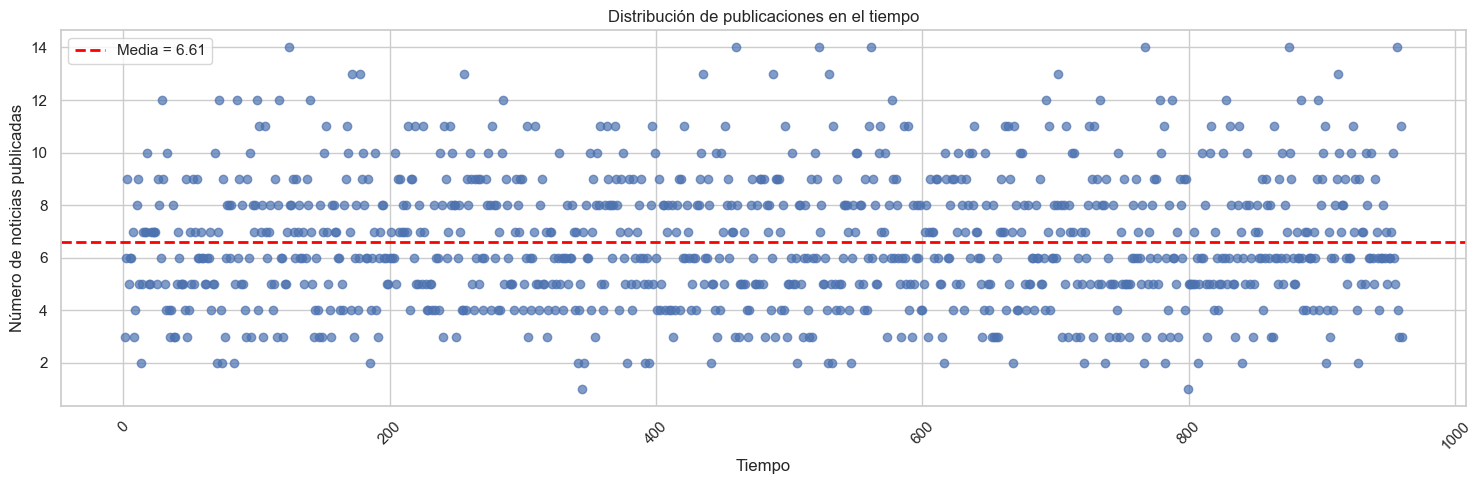

In [438]:
plt.figure(figsize=(15, 5))

plt.scatter(noticias_horas['tiempo'], noticias_horas['num_noticias_publicadas'], alpha=0.7)

media = noticias_horas['num_noticias_publicadas'].mean()
plt.axhline(media, color='red', linestyle='--', linewidth=2, label=f'Media = {media:.2f}')

plt.xlabel('Tiempo')
plt.ylabel('Número de noticias publicadas')
plt.title('Distribución de publicaciones en el tiempo')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Visualizamos las horas en la que más noticias se publican.

In [440]:
noticias_horas[noticias_horas['num_noticias_publicadas'] == noticias_horas['num_noticias_publicadas'].max()]

tiempo  num_noticias_publicadas
0     956                       14
1     767                       14
2     561                       14
3     522                       14
4     875                       14
5     124                       14
6     460                       14

Ahora visualizamos las horas en la que menos noticias se publican.

In [442]:
noticias_horas[noticias_horas['num_noticias_publicadas'] == noticias_horas['num_noticias_publicadas'].min()]

tiempo  num_noticias_publicadas
956     799                        1
957     344                        1

In [443]:
noticias_horas.describe()

tiempo  num_noticias_publicadas
count  958.000000               958.000000
mean   480.818372                 6.612735
std    277.246271                 2.475655
min      1.000000                 1.000000
25%    241.250000                 5.000000
50%    480.500000                 6.000000
75%    720.750000                 8.000000
max    960.000000                14.000000

In [444]:
print(f'Se publican una media de {round(noticias_horas['num_noticias_publicadas'].mean(),2)} noticias cada hora.')

Se publican una media de 6.61 noticias cada hora.


In [445]:
print(f'El maximo de noticias que se han publicado en una hora son {round(noticias_horas['num_noticias_publicadas'].max(),2)} noticias.')

El maximo de noticias que se han publicado en una hora son 14 noticias.


In [446]:
print(f'El minimo de noticias que se han publicado en una hora son {round(noticias_horas['num_noticias_publicadas'].min(),2)} noticias.')

El minimo de noticias que se han publicado en una hora son 1 noticias.


Vemos que en la mayoría de las horas se comparten entre 5 y 8 noticias.

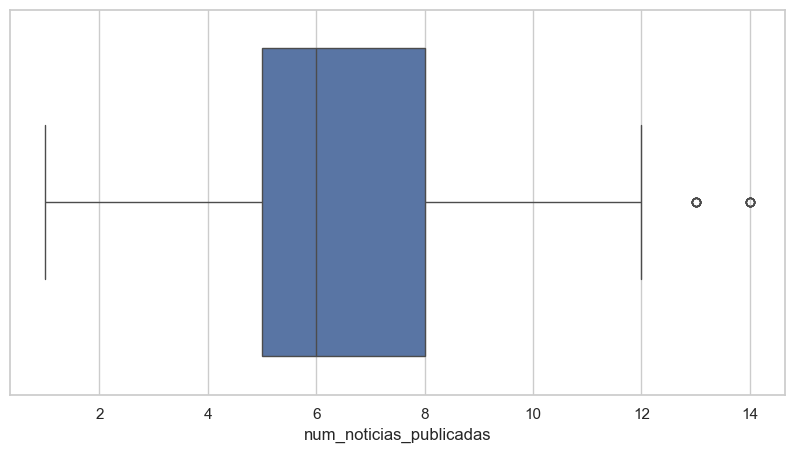

In [448]:
plt.figure(figsize=(10,5))
sns.boxplot(x=noticias_horas['num_noticias_publicadas'])
plt.show()

Vemos que la mayoría de noticias se publican entre las horas 200 y 750

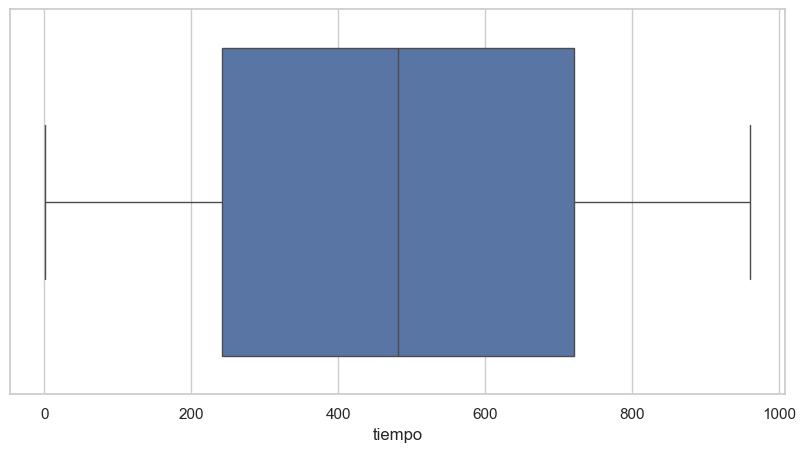

In [450]:
plt.figure(figsize=(10,5))
sns.boxplot(x=noticias_horas['tiempo'])
plt.show()

Ahora vamos a ver las noticias publicadas por día

In [452]:
fecha_inicio = pd.Timestamp('2022-09-01 07:00:00')  # Hora de inicio

df_tiempo['fecha_tiempo'] = (fecha_inicio + pd.to_timedelta(df_tiempo['tiempo'], unit='h')).dt.date
df_tiempo['hora_tiempo'] = (fecha_inicio + pd.to_timedelta(df_tiempo['tiempo'], unit='h')).dt.time

In [453]:
df_10=df_tiempo.groupby(['fecha_tiempo']).agg({'tiempo':'count'}).reset_index() 
df_10.rename(columns={'tiempo':'Nº noticias publicadas'},inplace=True)
df_10.sort_values(by='fecha_tiempo',inplace=True) # ordenamos el df por dia

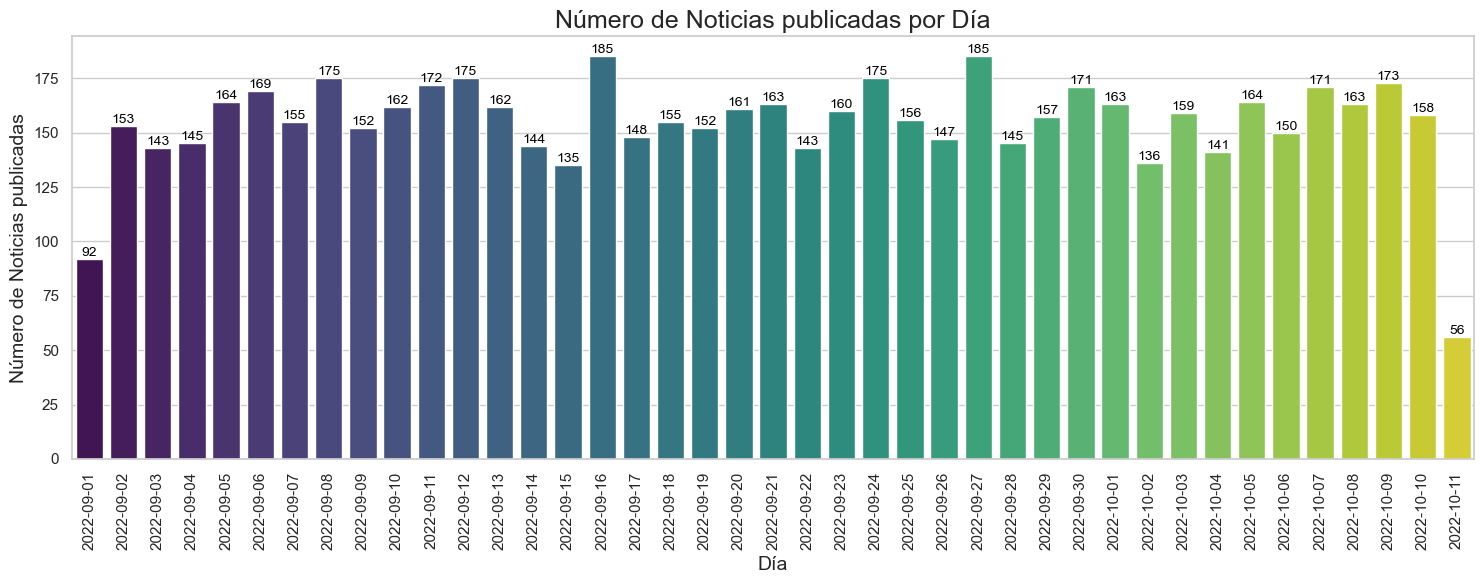

In [454]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 6))
barplot = sns.barplot(
    x='fecha_tiempo',
    y='Nº noticias publicadas',
    hue='fecha_tiempo', 
    data=df_10,
    palette='viridis',
    legend=False)

for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{int(height)}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     fontsize=10, color='black')

plt.title('Número de Noticias publicadas por Día', fontsize=18)
plt.xlabel('Día', fontsize=14)
plt.ylabel('Número de Noticias publicadas', fontsize=14)


plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Los días que más noticias se han publicado son el 16 y 27 de septiembre del 2022, con un total de 185 noticias publicadas cada día.

In [456]:
df_10[df_10['Nº noticias publicadas']==df_10['Nº noticias publicadas'].max()]

fecha_tiempo  Nº noticias publicadas
15   2022-09-16                     185
26   2022-09-27                     185

El día que menos noticias se han publicado es el 11 de octubre de 2022, con un total de 56 noticias publicadas.

In [458]:
df_10[df_10['Nº noticias publicadas']==df_10['Nº noticias publicadas'].min()]

fecha_tiempo  Nº noticias publicadas
40   2022-10-11                      56

Ahora vamos a ver las noticias publicadas por horas.

In [460]:
df_11=df_tiempo.groupby(['hora_tiempo']).agg({'tiempo':'count'}).reset_index() 
df_11.rename(columns={'tiempo':'Nº noticias publicadas'},inplace=True)
df_11.sort_values(by='hora_tiempo',inplace=True) 

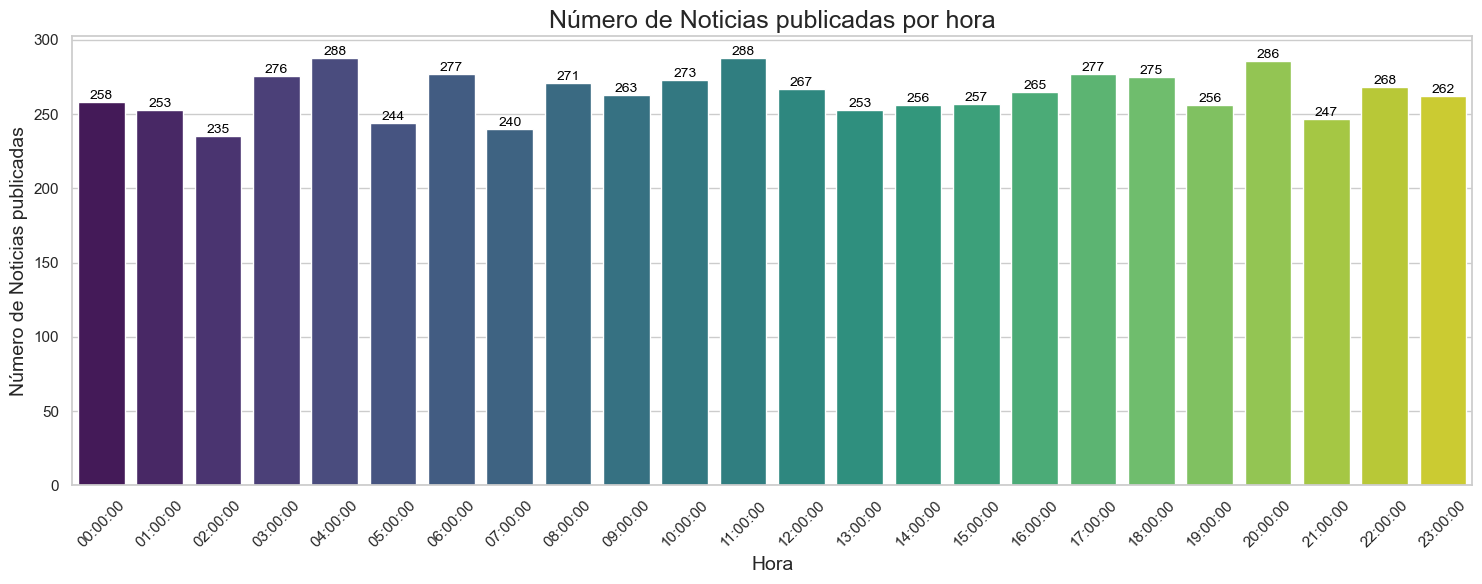

In [461]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 6))
barplot = sns.barplot(
    x='hora_tiempo',
    y='Nº noticias publicadas',
    hue='hora_tiempo', 
    data=df_11,
    palette='viridis',
    legend=False)

for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{int(height)}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     fontsize=10, color='black')

plt.title('Número de Noticias publicadas por hora', fontsize=18)
plt.xlabel('Hora', fontsize=14)
plt.ylabel('Número de Noticias publicadas', fontsize=14)


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [462]:
df_11[df_11['Nº noticias publicadas']==df_11['Nº noticias publicadas'].max()]

hora_tiempo  Nº noticias publicadas
4     04:00:00                     288
11    11:00:00                     288

Las horas en las que menos noticias se publican son las 02:00, con un total de 235 noticias publicadas

In [464]:
df_11[df_11['Nº noticias publicadas']==df_11['Nº noticias publicadas'].min()]

hora_tiempo  Nº noticias publicadas
2    02:00:00                     235

#### Resumen

**Como resumen de este análisis podemos sacar:**

* La tabla df_tiempo consta de 6335 filas y 2 columnas, la columna "id" de tipo int64 y la columna "tiempo" de tipo object.
* No hay valores nulos en la tabla.
* En las horas 956, 767, 561, 522, 875, 124 y 460 son cuando más noticias se han publicado, 14 noticias en cada hora.
* En las horas 799 y 344 son cuando menos noticias se han publicado, 1 noticias en cada hora.
* Las 11:00 y las 04:00 son las horas cuando más noticias se publican, 288 noticias cada hora.
* Las 02:00 es la hora cuando menos noticias se publican, 235 noticias.
* Se publican una media de 6.61 noticias cada hora.
* El día que más noticias se publicaron fue el 16/09/2022 y el 27/09/2022, con un total de 185 noticias cada día.
* El día que menos noticias se publicaron fue el 11/10/2022, con un total de 56 noticias publicadas.

### EDA tabla df_tipo

In [468]:
df_tipo.head()

id     tipo
0  3608  Columna
1  4869  Columna
2   139  Columna
3  3424  Columna
4  1718  Columna

#### Tipos de datos.

La tabla Tipos de datos se componen de la columna 'id' de tipo int64 que representa el número de identificador único para cada noticia  y la columna 'tipo' de tipo object que nos muestra el tipo de noticia. Por lo que a simple vista parece que los tipos de datos son correctos.

In [471]:
df_tipo.dtypes

id       int64
tipo    object
dtype: object

#### Dimensiones

La tabla tipo consta de 6029 filas y dos columnas.

In [474]:
df_tipo.shape

(6029, 2)

In [475]:
print(f'Nos llama la atención que tenga {df_tiempo.shape[0]-df_tipo.shape[0]} filas menos que el resto de DataFrames')

Nos llama la atención que tenga 306 filas menos que el resto de DataFrames


Lo que nos indica que de 306 noticias no tenemos idea de cuál es el tipo de noticia.

#### Duplicados

Comprobamos que no hay ninguna fila de datos duplicada.

In [479]:
print(f"Cantidad de valores duplicados: {df_tipo.duplicated().sum()}")

Cantidad de valores duplicados: 0


Calculamos el número de valores únicos y visualizamos cuáles son:

In [481]:
print(f' La columna "tipo" tiene un total de {df_tipo['tipo'].nunique(dropna=False)} valores unicos')

 La columna "tipo" tiene un total de 21 valores unicos


In [482]:
df_tipo['tipo'].unique()

array(['Columna', 'Artículo de opinión', 'Carta al editor', 'Entrevista',
       'Reportaje', 'Crónica', 'Noticia de última hora', 'Editorial',
       'Reseña', 'Crítica', 'Análisis', 'Entrevista exclusiva',
       'Columna de humor', 'Noticia local', 'Noticia internacional',
       'Artículo de investigación', 'Entrevista a fondo',
       'Entrevista en profundidad', 'Opinión del lector',
       'Reportaje especial', 'Noticia destacada'], dtype=object)

#### Nulos

La tabla no contiene valores nulos en ninguna de sus dos columnas.

In [485]:
df_tipo.isnull().sum()

id      0
tipo    0
dtype: int64

#### Analisis

Primero vamos a visualizar el número de noticias que hay de cada tipo.

In [488]:
Num_tipos_noticias = df_tipo.groupby('tipo')['id'].count().reset_index(name='Nº de noticias').sort_values(by='Nº de noticias')
                                                            

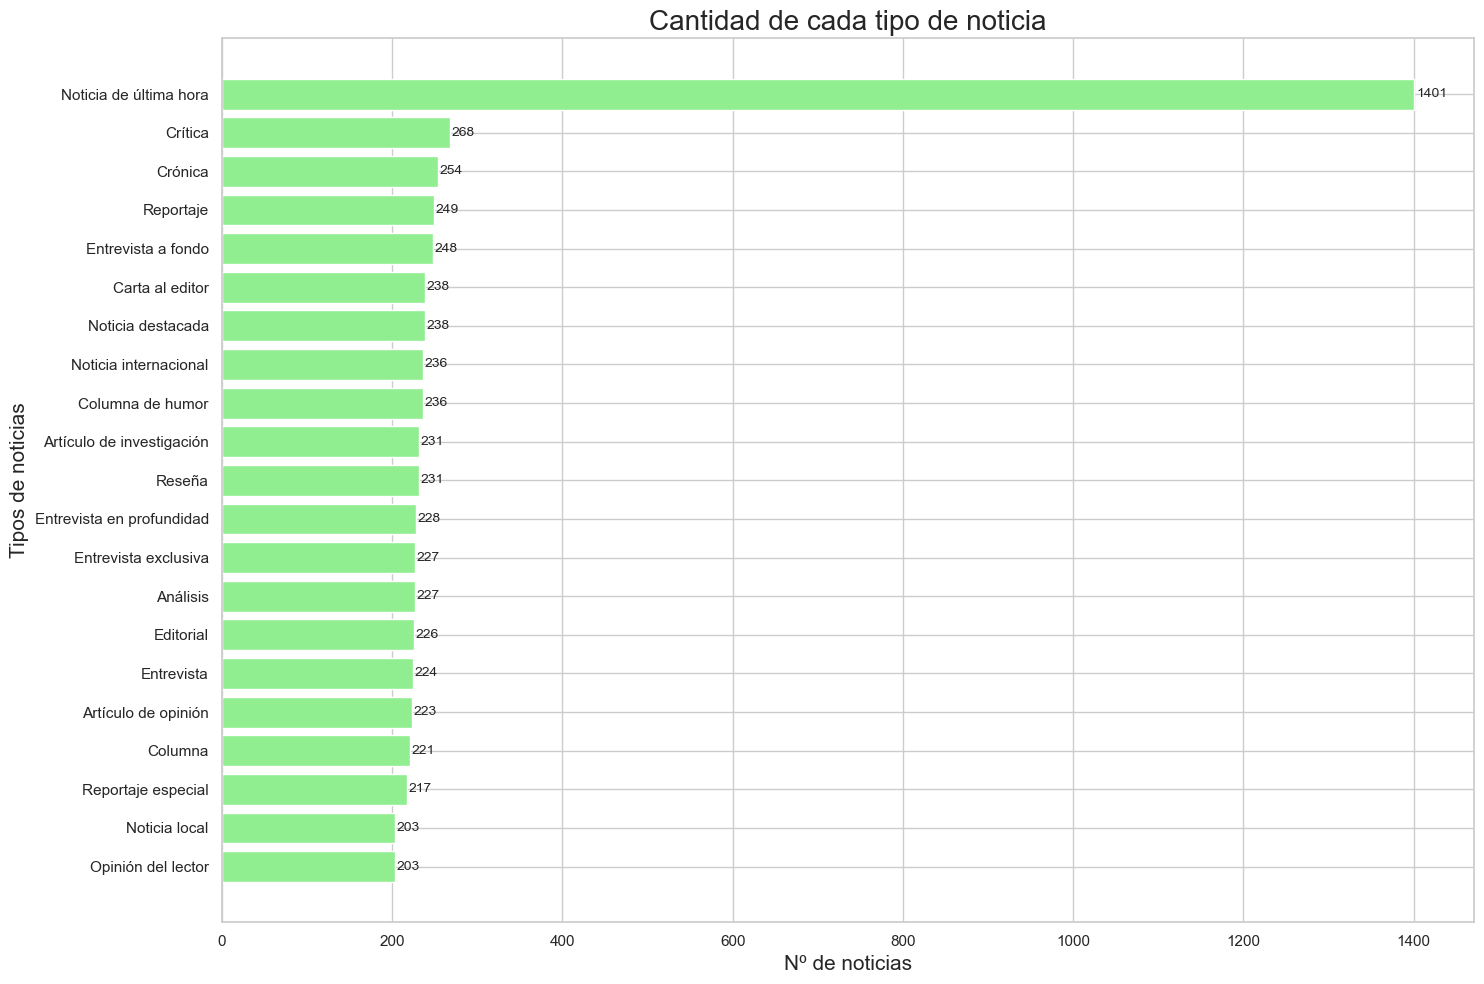

In [489]:
plt.figure(figsize=(15, 10))
bars = plt.barh(Num_tipos_noticias['tipo'], Num_tipos_noticias['Nº de noticias'], color='lightgreen')


for bar in bars:
    width = bar.get_width() 
    plt.text(width + 2, bar.get_y() + bar.get_height() / 2,
             str(width), ha='left', va='center', fontsize=10)


plt.title('Cantidad de cada tipo de noticia', fontsize=20)
plt.ylabel('Tipos de noticias', fontsize=15)
plt.xlabel('Nº de noticias', fontsize=15)
plt.xticks(rotation=0)


plt.tight_layout()
plt.show()

El tipo de noticia más común en la tabla es la 'Noticia de última hora' con un total de 1401 noticias publicadas.

In [491]:
tipo_mas_publicada = Num_tipos_noticias[Num_tipos_noticias['Nº de noticias']==Num_tipos_noticias['Nº de noticias'].max()]
tipo_mas_publicada

tipo  Nº de noticias
13  Noticia de última hora            1401

Por el contrario, las noticias que menos se publican son las 'Opinión del lector' y las 'Noticia local' con un total de 203 noticias publicadas.

In [493]:
tipo_menos_publicada = Num_tipos_noticias[Num_tipos_noticias['Nº de noticias']==Num_tipos_noticias['Nº de noticias'].min()]
tipo_menos_publicada

tipo  Nº de noticias
17  Opinión del lector             203
16       Noticia local             203

Observamos que las noticias de tipo 'Noticia de última hora' se publican casi 5 veces más que la media de publicación de todos los tipos de noticias

In [495]:
round(tipo_mas_publicada['Nº de noticias'].sum()/Num_tipos_noticias['Nº de noticias'].mean(),2)

4.88

Esto tiene sentido, ya que las noticias de última hora son una constante en cualquier periódico digital, ya que reflejan la actualidad de manera continua.

Ahora vamos a visualizar las estadísticas básicas y  la distribución del número de cada tipo de noticias.

In [498]:
Num_tipos_noticias.describe()

Nº de noticias
count       21.000000
mean       287.095238
std        255.687486
min        203.000000
25%        224.000000
50%        231.000000
75%        238.000000
max       1401.000000

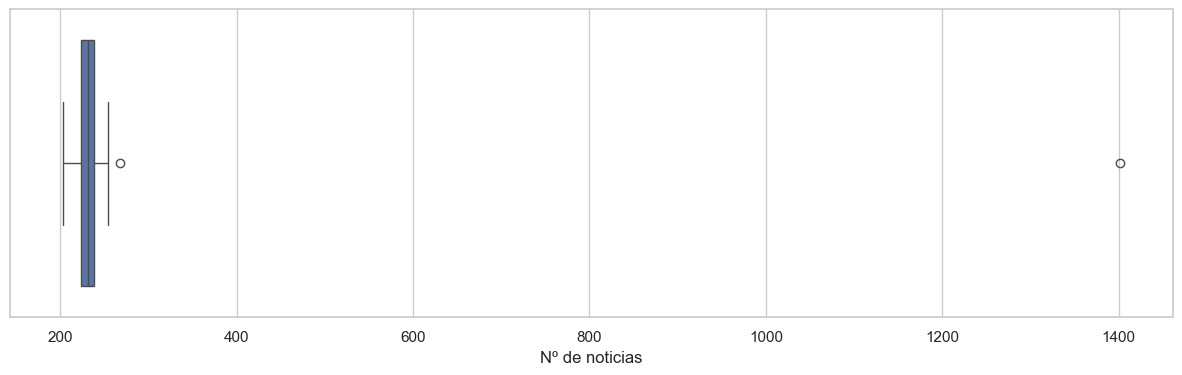

In [499]:
plt.figure(figsize=(15,4))
sns.boxplot(x=Num_tipos_noticias["Nº de noticias"])
plt.show()

#### Resumen

**Como resumen de este análisis podemos sacar:**

* la tabla df_tipo está compuesta por 6029  filas y 2 columnas, la columna "id" de tipo int64 y la columna "tipo" de tipo object.
* No hay valores nulos en la tabla.
* Hay 21 tipos de noticias.
* La "Noticia de última hora" es el tipo de noticia que más se repite con 1401 noticias de este tipo, lo que supone casi 5 veces más que la media del resto de tipos de noticias.
* La "noticia local" y "opinión del lector" es el tipo de noticia que menos se repite, con 203 noticias de cada tipo.
* La media de noticias de cada tipo son 231.

## EDA CONJUNTO

In [503]:
# Primero cambiamos los nombres de las columnas 'id' para que cada df tenga una columna con diferente nombre pero que represente el id de la noticia 

df_fake.rename(columns={'id': 'id_fake'},inplace=True)
df_info.rename(columns={'id': 'id_info'},inplace=True)
df_pais_idioma.rename(columns={'id': 'id_pais_idioma'},inplace=True)
df_tiempo.rename(columns={'id': 'id_tiempo'},inplace=True)
df_tipo.rename(columns={'id': 'id_tipo'},inplace=True)
df_fuente.rename(columns={'id': 'id_fuente'},inplace=True)

In [504]:
df_completo = df_contenidos.merge(df_compartir_tiempo, left_on="id_contenido", right_on="id_compartir", how="outer") \
              .merge(df_fake, left_on="id_contenido", right_on="id_fake", how="outer") \
              .merge(df_info, left_on="id_contenido", right_on="id_info", how="outer") \
              .merge(df_metadatos, left_on="id_contenido", right_on="t_id", how="outer") \
              .merge(df_pais_idioma, left_on="id_contenido", right_on="id_pais_idioma", how="outer") \
              .merge(df_tiempo, left_on="id_contenido", right_on="id_tiempo", how="outer") \
              .merge(df_tipo, left_on="id_contenido", right_on="id_tipo", how="outer") \
              .merge(df_fuente, left_on="id_contenido", right_on="id_fuente", how="outer")

In [505]:
# Borramos las columnas repetidas de la tabla completa

df_completo.drop(['id_compartir', 'id_fake','id_info','t_id','id_pais_idioma','id_tiempo','id_tipo','id_fuente'], axis=1,inplace = True)

### Algunas preguntas:

Patrones en el contenido textual:

1. ¿Las noticias FAKE tienden a tener títulos más largos o más cortos que las REAL? (longitud del título/texto)
2. ¿Existen ciertos autores que publican más noticias FAKE que otros?


Comportamiento temporal:

1. ¿En qué momentos del día se publican más noticias falsas vs reales? (columna 'tiempo' y 'hora')
2. ¿Hay diferencias en la duración de lectura de las noticias reales vs falsas? (columna 'duracion')
3. ¿Las noticias FAKE suelen compartirse más rápido o más veces que las reales? (relación entre 'compartir' y 'tiempo')


Engagement y métricas de interacción:


1. ¿Las noticias FAKE tienen más o menos visitas que las reales?
2. ¿Se guardan más las noticias reales como favoritas o las falsas?
3. ¿Hay una relación entre el número de visitas y la cantidad de veces que se comparte una noticia?
4. ¿Ciertas fuentes publican más noticias falsas que otras?


Correlaciones y relaciones entre variables:

1. ¿Existe una correlación entre la cantidad de veces que una noticia es compartida y su veracidad?
2. ¿Hay una relación entre el tiempo de lectura y si una noticia es falsa o real?
3. ¿Ciertas categorías de noticias (género/tipo) tienen más probabilidades de ser FAKE?

Patrones geográficos:
1. ¿En qué países hay más noticias falsas?

#### Patrones en el contenido textual

##### 1. ¿Las noticias FAKE tienden a tener títulos más largos o más cortos que las REAL? (longitud del título/texto)

In [509]:
df_completo_copia1 = df_completo.copy() # Hacemos una copia para no modificar nuestro DF original

In [510]:
df_real = df_completo[df_completo['fake']=='REAL']
df_fake = df_completo[df_completo['fake']=='FAKE']

In [511]:
df_completo_copia1['longitud_titulo'] = df_completo_copia1['titulo'].apply(len)

In [512]:
df_completo_copia1['longitud_titulo'].describe()

count    6335.000000
mean       65.279242
std        23.729714
min         5.000000
25%        49.000000
50%        64.000000
75%        78.000000
max       289.000000
Name: longitud_titulo, dtype: float64

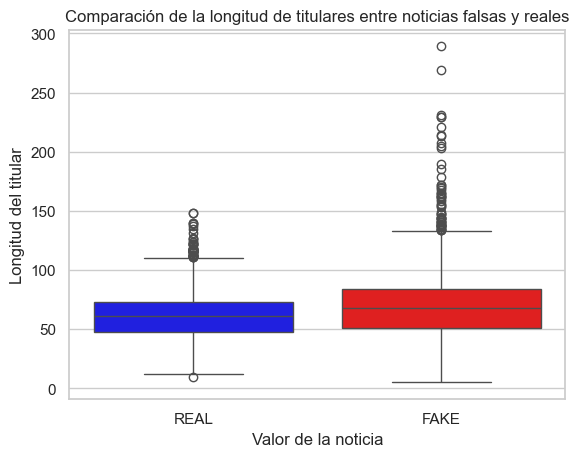

In [513]:
sns.boxplot(x='fake', y='longitud_titulo', data=df_completo_copia1, hue='fake', palette=['blue', 'red'], legend=False)

# Personalización del gráfico
plt.xlabel("Valor de la noticia")
plt.ylabel("Longitud del titular")
plt.title("Comparación de la longitud de titulares entre noticias falsas y reales")
plt.show()

In [514]:
df_completo_copia1['varianza_titulo'] = df_completo_copia1['titulo'].apply(lambda x: np.var([len(word) for word in x.split()]))

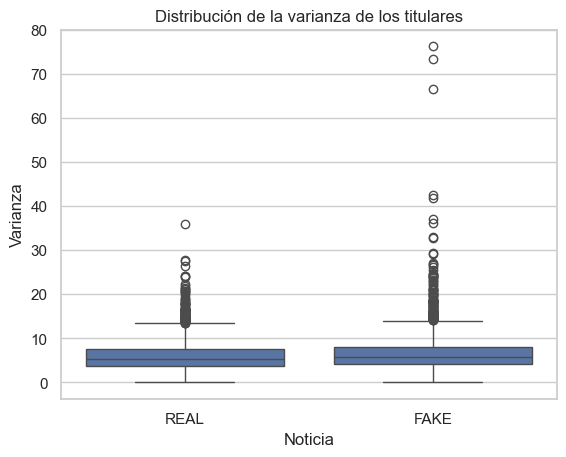

In [515]:
sns.boxplot(
    x='fake',
    y='varianza_titulo',
    data=df_completo_copia1
)
plt.title("Distribución de la varianza de los titulares")
plt.xlabel("Noticia")
plt.ylabel("Varianza")
plt.show()
plt.show()

***Conclusión***

- Las noticias falsas tienen una mayor variabilidad en la longitud de los títulos: outliers más dispersos y bigotes más alargados. Entonces: las noticias falsas varían considerablemente y algunas noticias tienen títulos muy largos.

- Las noticias reales son más consistentes en la longitud de los títulos. Tienen menos dispersión, bigotes más cortos y la caja es más estrecha.

- La diferencia entre las medianas no es enorme, entonces no hay una diferencia radical en la longitud media de los títulos entre las noticias, aunque la variabilidad es mucho mayor en las noticias falsas.

- Aunque la variancia parecía ser un indicador, no hay correlación y la varianza del titular no es una característica útil para diferenciar noticias falsas de reales.

##### 2. ¿Existen ciertos autores que publican más noticias FAKE que otros?

In [518]:
df_completo_copia2 = df_completo.copy() # Hacemos una copia para no modificar nuestro DF original

In [519]:
df_completo_copia2 = df_completo_copia2.groupby(['autor','fake'])['texto'].count().unstack(fill_value=0).reset_index()
df_completo_copia2['% FAKE'] = df_completo_copia2['FAKE'] / (df_completo_copia2['FAKE'] + df_completo_copia2['REAL']) * 100
df_completo_copia2 = df_completo_copia2.sort_values(by='% FAKE',ascending =True)

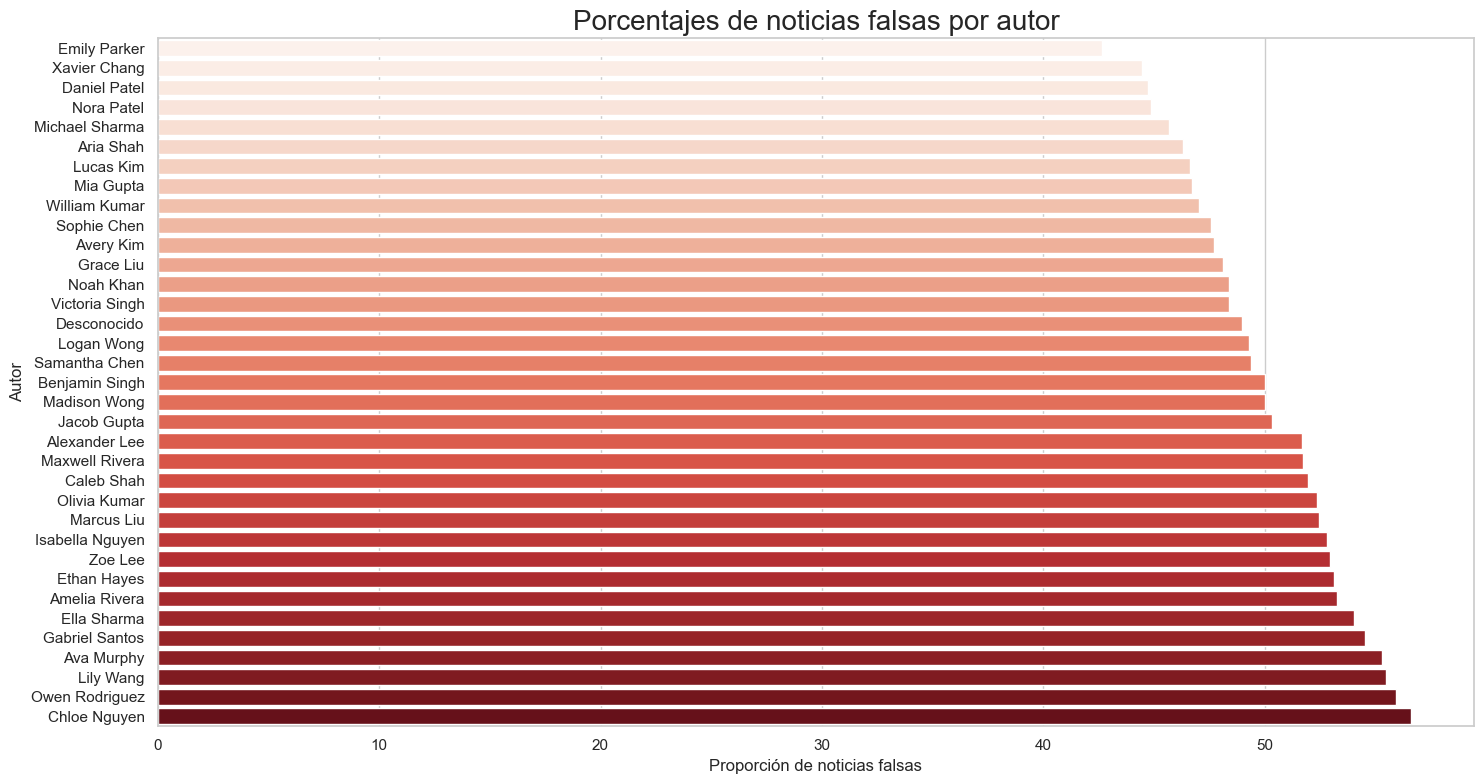

In [520]:
plt.figure(figsize=(15, 8))
sns.barplot(
    x='% FAKE',
    y='autor',
    data=df_completo_copia2,
    hue='autor',
    palette='Reds',
    legend=False
)
plt.xlabel('Proporción de noticias falsas')
plt.ylabel('Autor')
plt.title('Porcentajes de noticias falsas por autor', fontsize = 20)
plt.tight_layout()
plt.show()

***Conclusiones:***

- No parece que sea significativo, todos los autores tienen porcentajes parecidos sobre la proporción de noticias falsas que publican.

#### Comportamiento temporal

##### 1. ¿En qué momentos del día se publican más noticias falsas y más reales?

In [524]:
df_completo_copia3 = df_completo.copy() # Hacemos una copia para no modificar nuestro DF original

In [525]:
df_completo_copia3 = df_completo_copia3.groupby(['hora_tiempo','fake'])['id_contenido'].count().reset_index(name='num_noticias').sort_values(by = 'hora_tiempo')

In [526]:
hora_real_original = df_completo_copia3[df_completo_copia3['fake'] == 'REAL']
hora_fake_original = df_completo_copia3[df_completo_copia3['fake'] == 'FAKE']

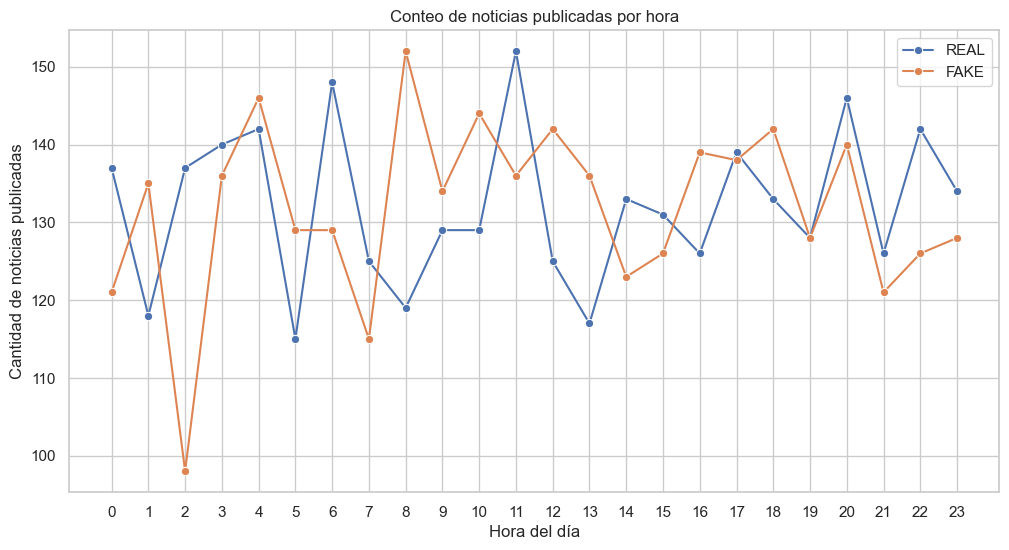

In [527]:
plt.figure(figsize=(12, 6))

#Realizamos una copia de los df para evitar problemas en la ejecucion
hora_real = hora_real_original.copy()
hora_fake = hora_fake_original.copy()

# Convertimos la columna 'hora_tiempo' en datetime y extraemos el num de hora.
hora_real['hora_tiempo'] = pd.to_datetime(hora_real['hora_tiempo'], format='%H:%M:%S').dt.hour
hora_fake['hora_tiempo'] = pd.to_datetime(hora_fake['hora_tiempo'], format='%H:%M:%S').dt.hour

sns.lineplot(x=hora_real['hora_tiempo'], y=hora_real['num_noticias'], label="REAL", marker="o")
sns.lineplot(x=hora_fake['hora_tiempo'], y=hora_fake['num_noticias'], label="FAKE", marker="o")
plt.xlabel("Hora del día")
plt.ylabel("Cantidad de noticias publicadas")
plt.title("Conteo de noticias publicadas por hora")
plt.xticks(range(0, 24))  # Asegurar que se muestren todas las horas
plt.legend()
plt.grid(True)
plt.show()

Visualizamos las horas a las que las más porcentaje de noticias 'fake' hay

In [529]:
df_completo_copia3 = df_completo_copia3.pivot(index='hora_tiempo', columns='fake', values='num_noticias').reset_index()

df_completo_copia3 ['% FAKE'] =  round(df_completo_copia3['FAKE'] / (df_completo_copia3['FAKE'] + df_completo_copia3['REAL'] )* 100,2)
df_completo_copia3.sort_values(by = '% FAKE', ascending = False).head()

fake hora_tiempo  FAKE  REAL  % FAKE
8       08:00:00   152   119   56.09
13      13:00:00   136   117   53.75
1       01:00:00   135   118   53.36
12      12:00:00   142   125   53.18
5       05:00:00   129   115   52.87

***Conclusiones:***

- A las 2 de la madrugada hay muchas menos noticias falsas en comparación con su distribución en otras horas.
- Sin embargo, a las 8 de la mañana se publican más noticias falsas que reales, alcanzando las noticias falsas su mayor pico.
- El pico de noticias reales publicadas se encuentra a las 11 de la mañana.
- El mínimo de noticias reales publicadas se encuentra  a las 5 de la madrugada.
- Aunque hay picos, no resulta estadísticamente significativo.

##### 2. ¿En qué momentos del día se publican más noticias falsas y más reales?

In [532]:
df_completo_copia4 = df_completo.copy() # Hacemos una copia para no modificar nuestro DF original

In [533]:
df_completo_copia4['duracion']

0       190.0
1       351.0
2       314.0
3        65.0
4        13.0
        ...  
6330    413.0
6331    185.0
6332    267.0
6333    548.0
6334    120.0
Name: duracion, Length: 6335, dtype: float64

In [534]:
df_real = df_completo_copia4[df_completo_copia4['fake'] == 'REAL']
df_fake = df_completo_copia4[df_completo_copia4['fake'] == 'FAKE']

In [535]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3171 entries, 0 to 3170
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_contenido      3171 non-null   int64  
 1   titulo            3171 non-null   object 
 2   texto             3171 non-null   object 
 3   tematica          3171 non-null   object 
 4   compartir_tiempo  3171 non-null   int64  
 5   fecha_compartir   3171 non-null   object 
 6   hora_compartir    3171 non-null   object 
 7   fake              3171 non-null   object 
 8   autor             3171 non-null   object 
 9   visitas           3171 non-null   float64
 10  compartir         3171 non-null   float64
 11  duracion          3171 non-null   float64
 12  favorito          3171 non-null   float64
 13  pais              3171 non-null   object 
 14  idioma            3171 non-null   object 
 15  tiempo            3171 non-null   int64  
 16  fecha_tiempo      3171 non-null   object 
 17  

In [536]:
#La columna 'duracion' contiene datos negativos, así que vamos a sacarlos porque no deberían estar (la duración en la que tardas en leer un noticia no puede ser negativa):

df_fake = df_fake[df_fake['duracion'] >= 0]
df_real = df_real[df_real['duracion'] >= 0]

In [537]:
stats_fake = df_fake['duracion'].describe()
stats_real = df_real['duracion'].describe()

print("Estadísticas de duración de noticias FAKE:\n", stats_fake)
print("\nEstadísticas de duración de noticias REAL:\n", stats_real)

Estadísticas de duración de noticias FAKE:
 count    3164.000000
mean      280.617573
std       156.480941
min         0.000000
25%       168.750000
50%       267.000000
75%       376.000000
max       940.000000
Name: duracion, dtype: float64

Estadísticas de duración de noticias REAL:
 count    3171.000000
mean      280.803532
std       153.344354
min         0.000000
25%       174.500000
50%       267.000000
75%       371.500000
max       961.000000
Name: duracion, dtype: float64


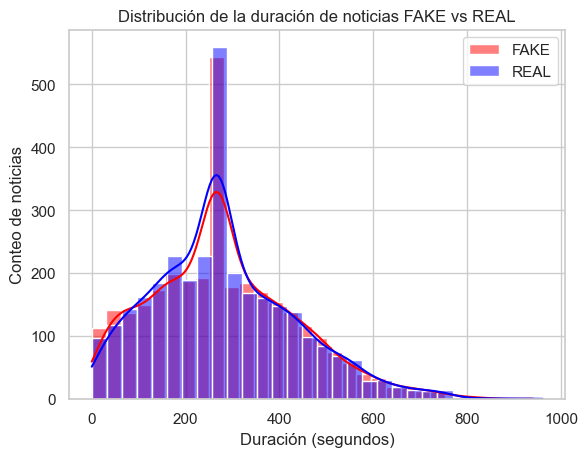

In [538]:
sns.histplot(df_fake['duracion'], color='red', label='FAKE', kde=True, bins=30, alpha=0.5)
sns.histplot(df_real['duracion'], color='blue', label='REAL', kde=True, bins=30, alpha=0.5)

plt.xlabel("Duración (segundos)")
plt.ylabel("Conteo de noticias")
plt.title("Distribución de la duración de noticias FAKE vs REAL")
plt.legend()
plt.grid(True)
plt.show()

In [539]:
from scipy.stats import ttest_ind

# Prueba t para comparar las medias
t_stat, p_value = ttest_ind(df_fake['duracion'], df_real['duracion'], equal_var=False)

print(f"Estadístico t: {t_stat}")
print(f"Valor p: {p_value}")

if p_value < 0.05:
    print("La diferencia en la duración de noticias FAKE vs REAL es significativa.")
else:
    print("No hay suficiente evidencia para decir que las noticias FAKE y REAL tienen diferentes duraciones.")

Estadístico t: -0.04776909351726431
Valor p: 0.9619017752571268
No hay suficiente evidencia para decir que las noticias FAKE y REAL tienen diferentes duraciones.


***Conclusiones:***

- A las 2 de la madrugada hay muchas menos noticias falsas en comparación con su distribución en otras horas.

##### 3. ¿Las noticias FAKE suelen compartirse más rápido o más veces que las reales?

In [542]:
df_completo_copia5 = df_completo.copy() # Hacemos una copia para no modificar nuestro DF original

In [543]:
df_fake = df_completo_copia5[df_completo_copia5['fake']== 'FAKE']

df_real = df_completo_copia5[df_completo_copia5['fake']== 'REAL']

Vemos en la visualización que la proporción de noticias 'Fake' y 'Reales' es prácticamente la misma

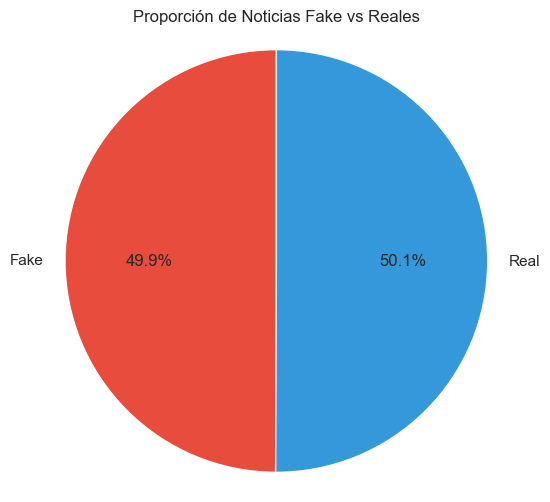

In [545]:
conteos = [len(df_fake), len(df_real)]
etiquetas = ['Fake', 'Real']
colores = ['#e74c3c', '#3498db'] 

plt.figure(figsize=(6, 6))
plt.pie(conteos, labels=etiquetas, colors=colores, autopct='%1.1f%%', startangle=90)
plt.title('Proporción de Noticias Fake vs Reales')
plt.axis('equal')
plt.show()


Ahora vamos a analizar cómo se distribuye el tiempo que tarda en compartirse una noticia desde su publicación. Este análisis nos permitirá entender si existen diferencias significativas en la velocidad con la que se difunden noticias reales y fake.

Para ello, representaremos gráficamente la densidad de los tiempos de compartición para ambos tipos de noticias, lo que nos ayudará a visualizar posibles patrones o comportamientos distintos en su difusión.

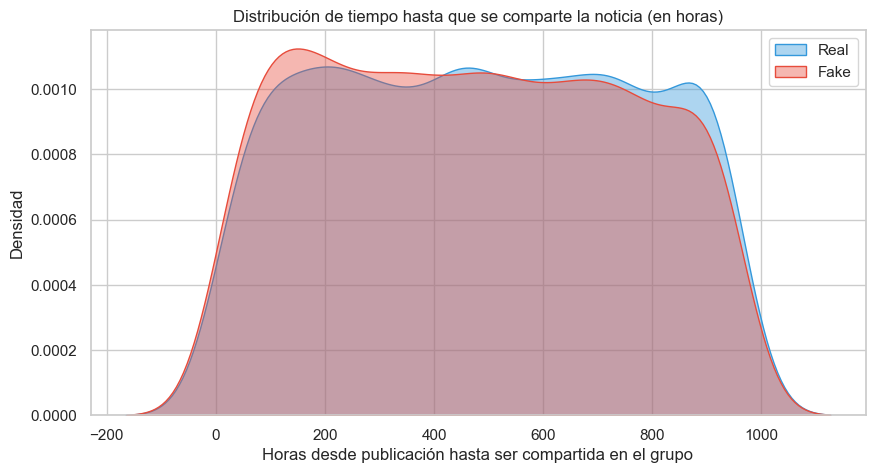

In [547]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df_real['compartir_tiempo'].dropna(), label='Real', fill=True, color='#3498db', alpha=0.4)
sns.kdeplot(df_fake['compartir_tiempo'].dropna(), label='Fake', fill=True, color='#e74c3c', alpha=0.4)

plt.title('Distribución de tiempo hasta que se comparte la noticia (en horas)')
plt.xlabel('Horas desde publicación hasta ser compartida en el grupo')
plt.ylabel('Densidad')
plt.legend()
plt.show()

***Conclusión:***

Como conclusión podemos decir que se comparten prácticamente el mismo número de noticias fake que real.

Al observar las curvas de densidad, podemos notar que las noticias fake tienden a compartirse más rápidamente, ya que su pico se encuentra más hacia la izquierda, indicando un menor tiempo desde su publicación hasta que son compartidas.

Por otro lado, las noticias reales presentan un pico desplazado hacia la derecha, lo que sugiere que suelen tardar más tiempo en difundirse en el grupo.

Esta diferencia puede indicar que las noticias falsas tienen una mayor velocidad de propagación, posiblemente debido a su contenido más llamativo o sensacionalista, que motiva a los usuarios a compartirlas más rápidamente.

Sin embargo, si las curvas se solapan considerablemente, esto puede indicar que la diferencia en los tiempos de compartición no es tan significativa, y que ambos tipos de noticias se difunden en intervalos de tiempo similares.

#### Engagement y métricas de interacción.

##### 1. ¿Las noticias FAKE tienen más o menos visitas que las reales?

In [551]:
df_completo_copia6 = df_completo.copy() # Hacemos una copia para no modificar nuestro DF original

In [552]:
df_completo_copia6.groupby('fake')['visitas'].describe().round(2).reset_index()

fake   count       mean        std    min        25%       50%       75%  \
0  FAKE  3164.0  501990.17  289336.35  309.0  252569.75  505003.0  754228.5   
1  REAL  3171.0  504161.78  291764.11  184.0  247134.00  511617.0  756422.0   

        max  
0  999864.0  
1  999300.0

Viendo los datos estadísticos básicos podemos deducir que no existe gran diferencia entre las visitas que reciben las noticias 'fake' de las noticias 'reales', aun así vamos a pintarlo en un gráfico para ver la distribución de manera más visual.

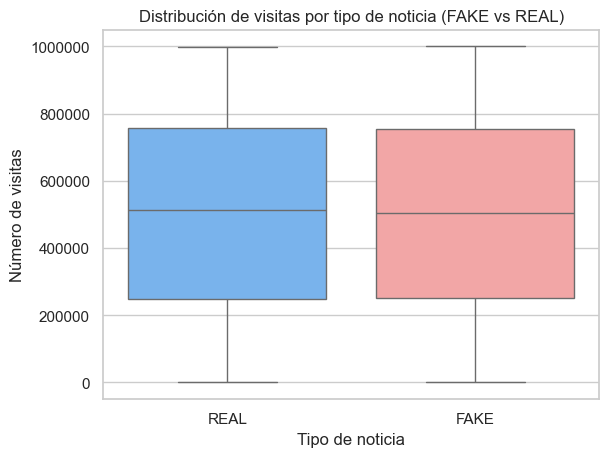

In [554]:
sns.boxplot(
    x='fake',
    y='visitas',
    hue='fake',
    data=df_completo_copia6,
    palette={'FAKE': '#ff9999', 'REAL': '#66b3ff'},
    legend=False
)

plt.title('Distribución de visitas por tipo de noticia (FAKE vs REAL)')
plt.xlabel('Tipo de noticia')
plt.ylabel('Número de visitas')

plt.ticklabel_format(style='plain', axis='y')

Ahora calculamos cuanto porcentaje supone la media de visitas que tiene cada tipo de noticias.

In [556]:
media_reales = df_completo_copia6[df_completo_copia6['fake'] == 'REAL']['visitas'].mean()
media_fake = df_completo_copia6[df_completo_copia6['fake'] == 'FAKE']['visitas'].mean()
diferencia = media_reales - media_fake
porcentaje = (diferencia / media_fake) * 100
print(f"Diferencia absoluta: {diferencia:.2f}")
print(f"Diferencia porcentual: {porcentaje:.2f}%")

Diferencia absoluta: 2171.61
Diferencia porcentual: 0.43%


***Conclusión***

Las noticias reales tienen un 0.43% de media más de visitas que las noticias 'fake' por lo que no podemos demostrar una relación entre la veracidad de una noticia y sus visitas.

##### 2. ¿Se guardan más las noticias reales como favoritas o las falsas?

In [559]:
df_completo_copia7 = df_completo.copy() # Hacemos una copia para no modificar nuestro DF original

In [560]:
df_completo_copia6.groupby('fake')['favorito'].describe().round(2).reset_index()

fake   count     mean      std  min     25%     50%      75%     max
0  FAKE  3164.0  4978.03  2808.34  5.0  2565.0  5004.0  7253.25  9997.0
1  REAL  3171.0  5022.21  2802.75  1.0  2689.5  5004.0  7355.50  9998.0

De nuevo no podemos ver una diferencia sustancial entre las veces que se guarda la noticia en favoritos y su veracidad, pero veámoslo gráficamente.

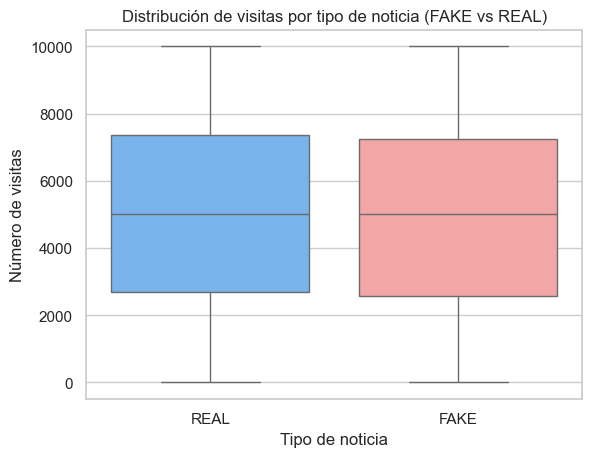

In [562]:
sns.boxplot(
    x='fake',
    y='favorito',
    hue='fake',
    data=df_completo_copia6,
    palette={'FAKE': '#ff9999', 'REAL': '#66b3ff'},
    legend=False
)

plt.title('Distribución de visitas por tipo de noticia (FAKE vs REAL)')
plt.xlabel('Tipo de noticia')
plt.ylabel('Número de visitas')

plt.ticklabel_format(style='plain', axis='y')

In [563]:
media_reales = df_completo_copia7[df_completo_copia7['fake'] == 'REAL']['favorito'].mean()
media_fake = df_completo_copia7[df_completo_copia7['fake'] == 'FAKE']['favorito'].mean()
diferencia = media_reales - media_fake
porcentaje = (diferencia / media_fake) * 100
print(f"Diferencia absoluta: {diferencia:.2f}")
print(f"Diferencia porcentual: {porcentaje:.2f}%")

Diferencia absoluta: 44.18
Diferencia porcentual: 0.89%


***Conclusión***

Las noticias reales se guardan en favoritos de media un 0.89% más que las noticias 'fake' por lo que no podemos demostrar una relación entre la veracidad de una noticia y el número de veces que se guarda en favorito.

##### 3. ¿Hay una relación entre el número de visitas y la cantidad de veces que se comparte una noticia?

In [566]:
df_completo_copia8 = df_completo[['visitas','compartir','fake']].copy() # Hacemos una copia para no modificar nuestro DF original

In [567]:
df_numericos = df_completo_copia8.select_dtypes(include=['number'])


In [568]:
df_numericos.corr()

visitas  compartir
visitas    1.000000   0.002443
compartir  0.002443   1.000000

Buscamos una correlación entre el número de visitas y las veces que se comparte una noticia, pero no encontramos una relación significativa. Por ello, decidimos dividir las noticias en 'reales' y 'fake' para analizar si en cada categoría se observa algún patrón distinto.

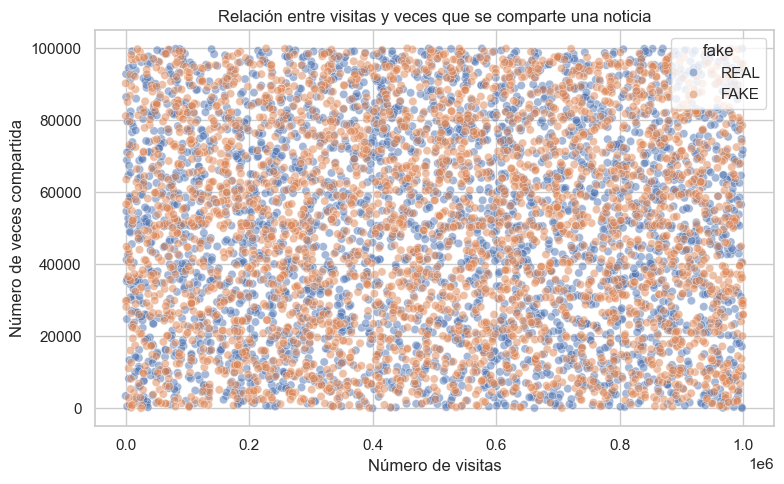

In [570]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_completo_copia8, x='visitas', y='compartir', hue='fake', alpha=0.5)
plt.title('Relación entre visitas y veces que se comparte una noticia')
plt.xlabel('Número de visitas')
plt.ylabel('Número de veces compartida')
plt.grid(True)
plt.tight_layout()
plt.show()

***Conclusiones:***

No se muestra correlación entre los valores 'visitas', 'compartir' y, además, visualmente no se aprecia ninguna relación entre las visitas que recibe una noticia, las veces que se comparte y su veracidad.

##### 4. ¿Ciertas fuentes publican más noticias falsas que otras?

In [573]:
df_completo_copia9 = df_completo[['fuente','fake']].copy() # Hacemos una copia para no modificar nuestro DF original

In [574]:
# Preparamos el DF para poder visualizarlo correctamente

df_porcentajes_autores_fake = round(( pd.crosstab(df_completo_copia9['fuente'], df_completo_copia9['fake'], normalize="index") * 100 ).reset_index().sort_values(by ="FAKE",ascending = False),2)

In [575]:
fig = px.bar(
    df_porcentajes_autores_fake,
    y="fuente",      
    x="FAKE",        
    orientation="h", 
    height=40*len(df_porcentajes_autores_fake),
    text="FAKE" 
)

fig.update_traces(
    marker_color="red",
    texttemplate='%{text:.1f}%',
    textposition="outside",
    textfont=dict(size=18, color="black")
)

fig.update_layout(
    plot_bgcolor="lightgray",
    paper_bgcolor="white",
    font=dict(family="Arial", size=15, color="black"),
    title="Porcentaje de noticias FAKE publicadas por cada fuente",
    title_x=0.5,
    xaxis_title="% noticias fake",
    yaxis_title="Fuentes",
    yaxis=dict(categoryorder="total ascending") 
)


fig.add_shape(
    type="line",
    x0=df_porcentajes_autores_fake["FAKE"].mean(),
    x1=df_porcentajes_autores_fake["FAKE"].mean(),
    y0=-0.5,
    y1=len(df_porcentajes_autores_fake["fuente"]) - 0.5,
    xref="x",
    yref="y",
    line=dict(color="black", width=3, dash="dot")
)

fig.show()

In [576]:
# Comprobación del numero de fuentes cuya proporcion de noticias fake publicadas es igual o superior al 50%

print(f" Hay {df_porcentajes_autores_fake[df_porcentajes_autores_fake["FAKE"] >= 50].shape[0]} fuentes cuya proporción de noticias Fake publicadas es igual o superior al 50%")

 Hay 18 fuentes cuya proporción de noticias Fake publicadas es igual o superior al 50%


In [577]:
# Comprobación del numero de fuentes cuya proporcion de noticias fake publicadas es inferior al 50%

print(f" Hay {df_porcentajes_autores_fake[df_porcentajes_autores_fake["FAKE"] < 50].shape[0]} fuentes cuya proporción de noticias Fake publicadas es inferior al 50%")

 Hay 15 fuentes cuya proporción de noticias Fake publicadas es inferior al 50%


***Conclusiones:***

- Más del 57% de las noticias de las fuentes: 'Frontline Times','Echo News' y 'Voice of the Nation' son Fake, por lo que podemos ver que son las fuentes menos fiables.
- Por el contrario, vemos que de las fuentes: 'City Beat', 'Star Sentinel' y 'World News Network' poco más del 43% de sus noticias son fake
- Hay 15 fuentes cuya proporción de noticias Fake publicadas es inferior al 50%
- Hay 18 fuentes cuya proporción de noticias Fake publicadas es igual o superior al 50%

#### Correlaciones y relaciones entre variables:

##### 1. ¿Existe una correlación entre la cantidad de veces que una noticia es compartida y su veracidad?

In [581]:
df_completo_copia10 = df_completo[['compartir','fake']].copy() # Hacemos una copia para no modificar nuestro DF original

Vamos a visualizar las distribuciones de las comparticiones de las noticias fake y reales.

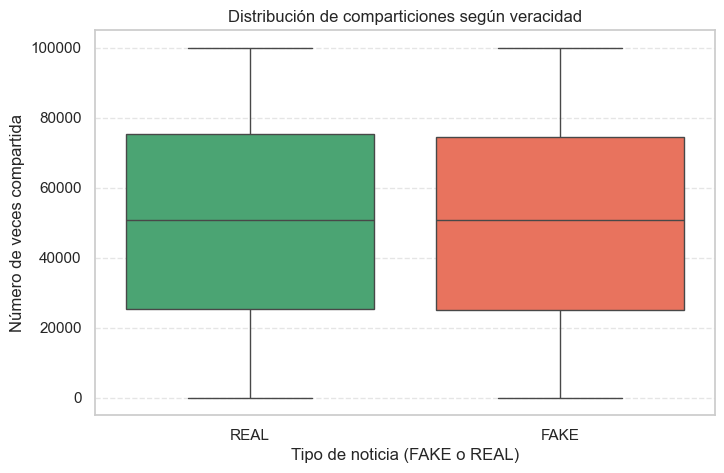

In [583]:
plt.figure(figsize=(8,5))
sns.boxplot(x='fake', y='compartir', data=df_completo_copia10, hue='fake', palette=['mediumseagreen', 'tomato'])
plt.title('Distribución de comparticiones según veracidad')
plt.xlabel('Tipo de noticia (FAKE o REAL)')
plt.ylabel('Número de veces compartida')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

A simple vista no podemos apreciar diferencias significativas entre las dos distribuciones, así que vamos a calcular cuanto varían sus medidas estadísticas básicas

In [585]:
distribucion_compartidos_fake = df_completo_copia10[df_completo_copia10['fake']=='FAKE'].describe()
distribucion_compartidos_real = df_completo_copia10[df_completo_copia10['fake']=='REAL'].describe()


porcentaje_diferencia = (distribucion_compartidos_fake - distribucion_compartidos_real) / distribucion_compartidos_real * 100


tabla_comparativa_pct = pd.concat([distribucion_compartidos_fake, distribucion_compartidos_real, porcentaje_diferencia], axis=1)


tabla_comparativa_pct.columns = ['FAKE', 'REAL', 'DIF_%']

tabla_comparativa_pct = tabla_comparativa_pct.round(2)

tabla_comparativa_pct

FAKE      REAL   DIF_%
count   3164.00   3171.00   -0.22
mean   49926.93  50478.06   -1.09
std    28864.33  28839.86    0.08
min       40.00     13.00  207.69
25%    25010.75  25396.50   -1.52
50%    50726.00  50726.00    0.00
75%    74572.25  75247.50   -0.90
max    99951.00  99933.00    0.02

***Conclusiones:***

- No se muestra correlación estadística entre las comparticiones de una noticia y su veracidad.

##### 2. ¿Hay una relación entre el tiempo de lectura y si una noticia es falsa o real?

In [588]:
df_completo_copia11 = df_completo[['duracion','fake']].copy() # Hacemos una copia para no modificar nuestro DF original

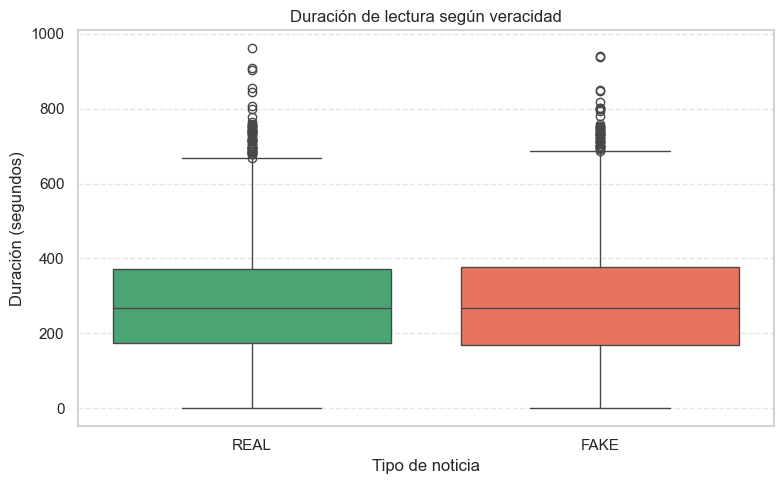

In [589]:
plt.figure(figsize=(8,5))
sns.boxplot(x='fake', y='duracion', data=df_completo_copia11,hue='fake', palette={'FAKE': 'tomato', 'REAL': 'mediumseagreen'})
plt.title('Duración de lectura según veracidad')
plt.xlabel('Tipo de noticia')
plt.ylabel('Duración (segundos)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [590]:
distribucion_duracion_fake = df_completo_copia11[df_completo_copia11['fake']=='FAKE'].describe()
distribucion_duracion_real = df_completo_copia11[df_completo_copia11['fake']=='REAL'].describe()


porcentaje_diferencia_duracion = (distribucion_duracion_fake - distribucion_duracion_real) / distribucion_duracion_real * 100


tabla_comparativa_distribucion = pd.concat([distribucion_duracion_fake, distribucion_duracion_real, porcentaje_diferencia_duracion], axis=1)


tabla_comparativa_distribucion.columns = ['FAKE', 'REAL', 'DIF_%']

tabla_comparativa_distribucion = tabla_comparativa_distribucion.round(2)

tabla_comparativa_distribucion

FAKE     REAL  DIF_%
count  3164.00  3171.00  -0.22
mean    280.62   280.80  -0.07
std     156.48   153.34   2.05
min       0.00     0.00    NaN
25%     168.75   174.50  -3.30
50%     267.00   267.00   0.00
75%     376.00   371.50   1.21
max     940.00   961.00  -2.19

***Conclusiones:***

- No se muestra correlación estadística entre el tiempo de lectura de una noticia y su veracidad.

##### 3. ¿Ciertas categorías de noticias (temática/tipo) tienen más probabilidades de ser FAKE?

In [593]:
df_completo_copia12 = df_completo[['tematica','tipo','fake']].copy() # Hacemos una copia para no modificar nuestro DF original

Primero vamos a analizar si las noticias de cierta temática tienen más probabilidades de ser Fake

In [595]:
# Preparamos nuestros datos para visualizarlos

df_porcentajes_tematica_fake = round(( pd.crosstab(df_completo_copia12['tematica'], df_completo_copia12['fake'], normalize="index") * 100 ).reset_index().sort_values(by ="FAKE",ascending = True),2)

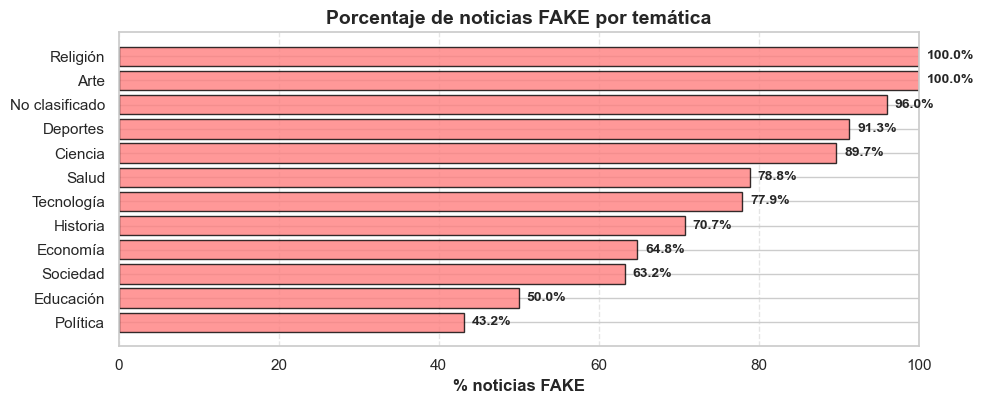

In [596]:
plt.figure(figsize=(10, len(df_porcentajes_tematica_fake)*0.35))

bars = plt.barh(df_porcentajes_tematica_fake['tematica'], df_porcentajes_tematica_fake['FAKE'], color='#ff7f7f', edgecolor='black', alpha=0.8)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.xlabel('% noticias FAKE', fontsize=12, fontweight='bold')
plt.title('Porcentaje de noticias FAKE por temática', fontsize=14, fontweight='bold')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

***Conclusiones:***

- El 100% de las noticias de temática "Arte" son FAKE.
- También, todas las noticias clasificadas como "Religión" son FAKE.
- Solo el 43% de las noticias políticas son FAKE. La mayoría en este caso serían reales.
- La mitad de las noticias sobre educación son falsas, la otra mitad reales.

***Ahora analizaremos si existe alguna relación entre el tipo de noticia y su veracidad.***

In [599]:
# Preparamos nuestros datos para visualizarlos

df_porcentajes_tipo_fake = round(( pd.crosstab(df_completo_copia12['tipo'], df_completo_copia12['fake'], normalize="index") * 100 ).reset_index().sort_values(by ="FAKE",ascending = True),2)

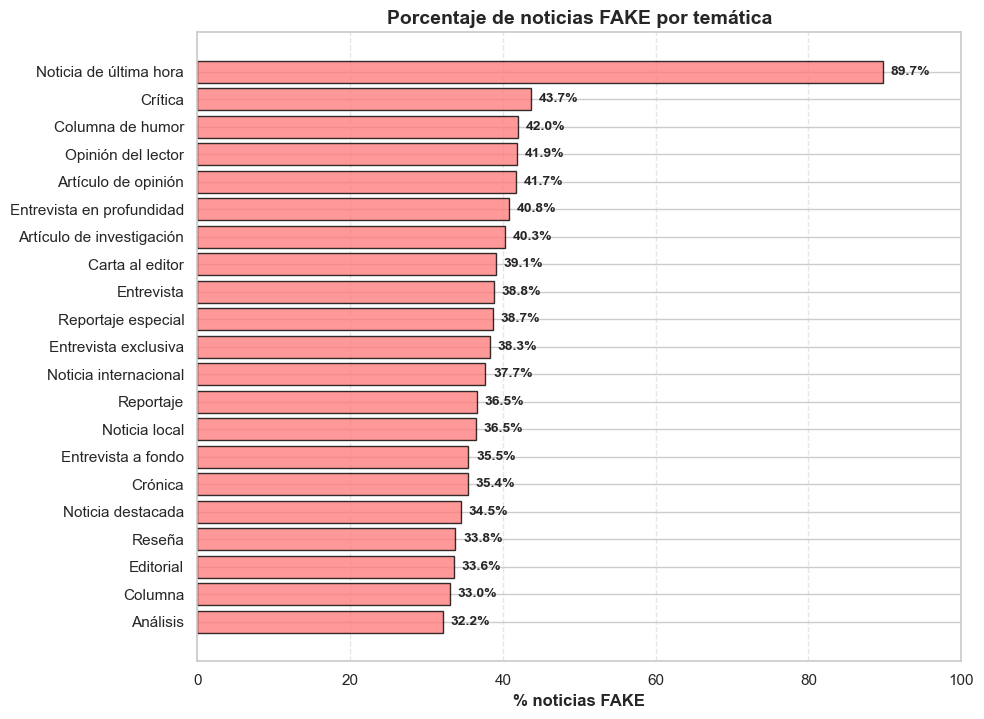

In [600]:
plt.figure(figsize=(10, len(df_porcentajes_tipo_fake)*0.35))

bars = plt.barh(df_porcentajes_tipo_fake['tipo'], df_porcentajes_tipo_fake['FAKE'], color='#ff7f7f', edgecolor='black', alpha=0.8)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.xlabel('% noticias FAKE', fontsize=12, fontweight='bold')
plt.title('Porcentaje de noticias FAKE por temática', fontsize=14, fontweight='bold')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

***Conclusiones:***

- Casi 9 de cada 10 noticias de Última hora, son falsas

- Tipos como "Crítica", "Columna de humor", "Opinión del lector" están en torno al 41-43% FAKE, lo cual es bastante equilibrado.

- "Análisis", "Columna", "Editorial", "Reseña" están entre el 32–34% FAKE, lo que indica que tienden a ser mayormente reales.

#### Patrones geográficos

In [603]:
df_completo_copia13 = df_completo[['pais','fake']].copy() # Hacemos una copia para no modificar nuestro DF original

In [604]:
# Preparamos nuestros datos para visualizarlos

df_porcentajes_pais_fake = round(( pd.crosstab(df_completo_copia13['pais'], df_completo_copia13['fake'], normalize="index") * 100 ).reset_index().sort_values(by ="FAKE",ascending = True),2)

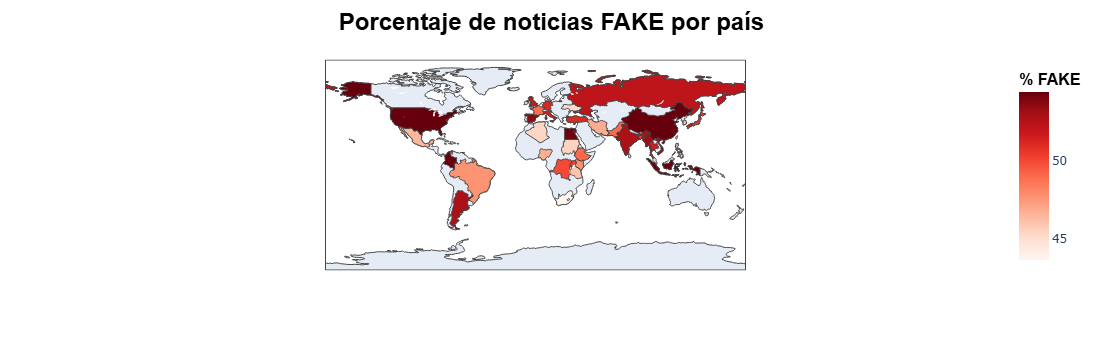

In [606]:
fig = px.choropleth(
    df_porcentajes_pais_fake,
    locations='pais', 
    locationmode='country names', 
    color='FAKE',
    color_continuous_scale='Reds',
)

fig.update_layout(
    title_text='Porcentaje de noticias FAKE por país',
    title_x=0.5,
    title_font=dict(size=24, family='Arial', color='black', weight='bold'),  # negrita
    height=350,
    width=600,
    coloraxis_colorbar=dict(
        title="% FAKE",
        title_font=dict(size=16, family='Arial', color='black', weight='bold')
    )
)

fig.show()

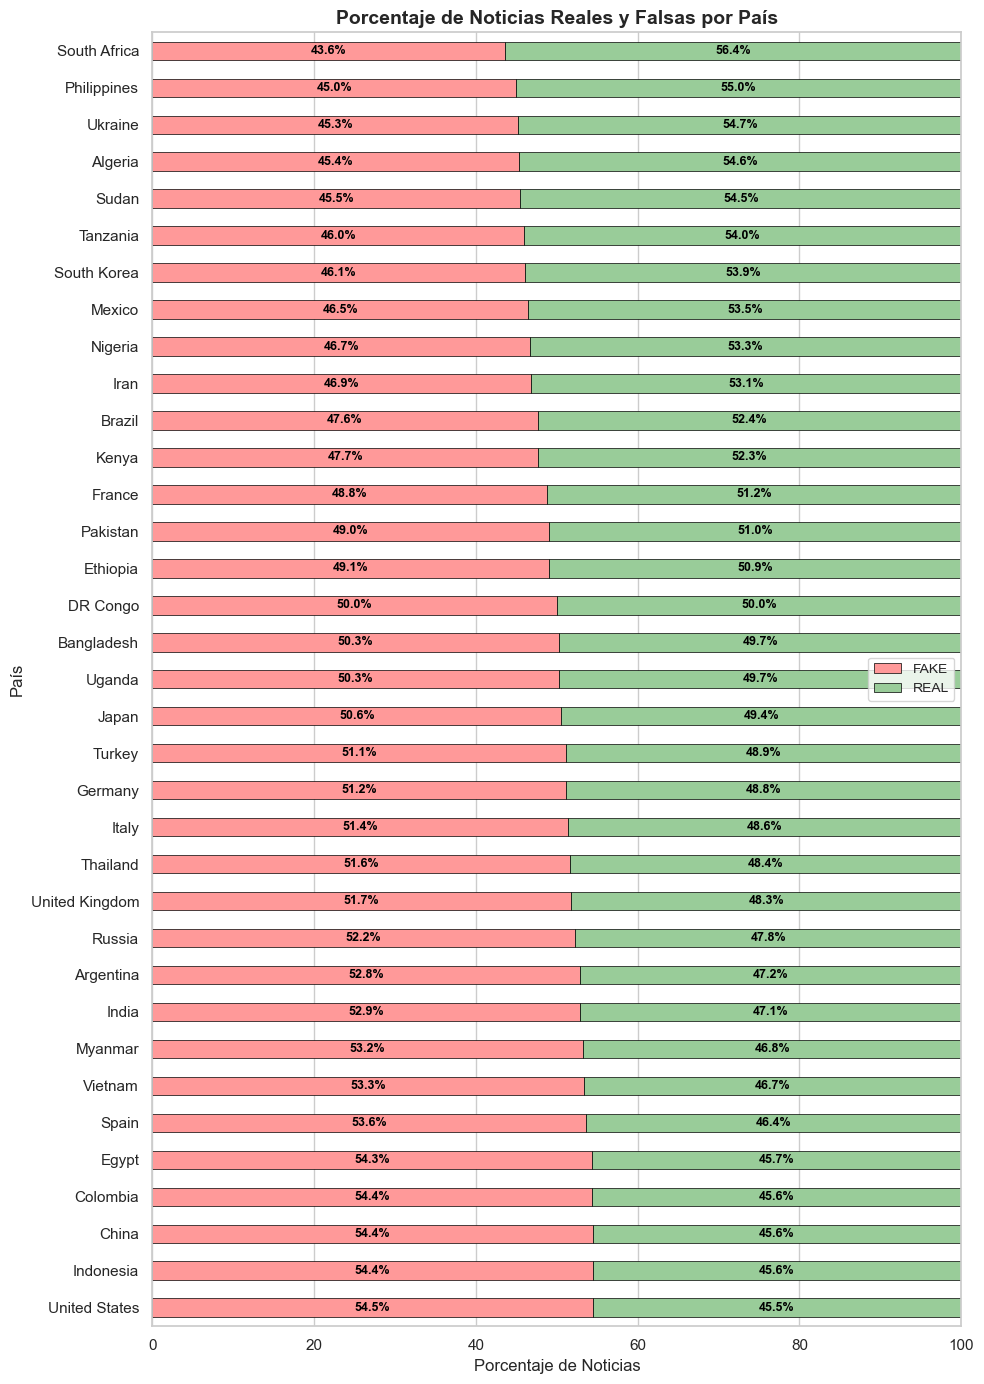

In [607]:
df_sorted = df_porcentajes_pais_fake.sort_values('FAKE', ascending=False)  # opcional: ordenar por FAKE


colors = ['#ff9999', '#99cc99']

ax = df_sorted.set_index('pais')[['FAKE', 'REAL']].plot(
    kind='barh',
    stacked=True,
    figsize=(10, len(df_sorted)*0.4),
    color=colors,
    edgecolor='black',
    linewidth=0.5
)


plt.title('Porcentaje de Noticias Reales y Falsas por País', fontsize=14, fontweight='bold')
plt.xlabel('Porcentaje de Noticias', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.xlim(0, 100)
plt.legend(fontsize=10)
plt.tight_layout()


for i, pais in enumerate(df_sorted['pais']):
    fake_pct = df_sorted.loc[df_sorted['pais'] == pais, 'FAKE'].values[0]
    real_pct = df_sorted.loc[df_sorted['pais'] == pais, 'REAL'].values[0]
    
   
    ax.text(fake_pct/2, i, f'{fake_pct:.1f}%', va='center', ha='center', color='black', fontweight='bold', fontsize=9)
    
    ax.text(fake_pct + real_pct/2, i, f'{real_pct:.1f}%', va='center', ha='center', color='black', fontweight='bold', fontsize=9)

plt.show()
